In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import py0
import maxent
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf
import networkx as nx
from keras.callbacks import ReduceLROnPlateau

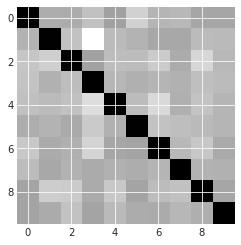

In [2]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
# defining a fully connected mobility matrix
dense_mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
dense_mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(dense_mobility_matrix, dense_mobility_matrix_diag)
dense_mobility_matrix_norm = dense_mobility_matrix / np.sum(dense_mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(dense_mobility_matrix))
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
true_node = 1
infections_compartments = [1,2]
C = len(compartments)

In [3]:
def gen_ref_traj(graph, beta_A = 0.025, beta_I=0.05, alpha =1/3, gamma=1/2, mu=1/7, M=10, C=4, timesteps=100,
                 mobility_matrix=dense_mobility_matrix, population=None, area= None, true_node=None):
    # sparsify mobility matrix for sparse graphs
    sparsed_mobility_matrix = py0.sparse_graph_mobility(graph, mobility_matrix)
    tmat = py0.TransitionMatrix(compartments, [1,2])
    tmat.add_transition('E', 'A', 1/alpha, 0) # calling this alpha
    tmat.add_transition('E', 'I', 1/gamma, 0) # calling this gamma
    tmat.add_transition('A', 'R',1/mu, 0) # mu
    tmat.add_transition('I', 'R', 1/mu, 0) # mu
    infect_fxn = py0.contact_infection_func(infections_compartments, area=area)
    model = py0.MetaModel(infect_fxn, timesteps, populations=np.array(population))
    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node true_node
    initial_exposed = 1/population[true_node]
    start[true_node,0] = initial_exposed
    sparsed_mobility_matrix_norm = sparsed_mobility_matrix / np.sum(sparsed_mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(sparsed_mobility_matrix_norm, tmat.value, start, np.array([beta_A,beta_I]))[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj


Plotting 10 patches in a 3 x 4 grid


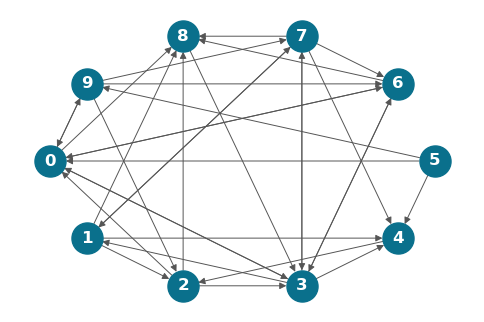

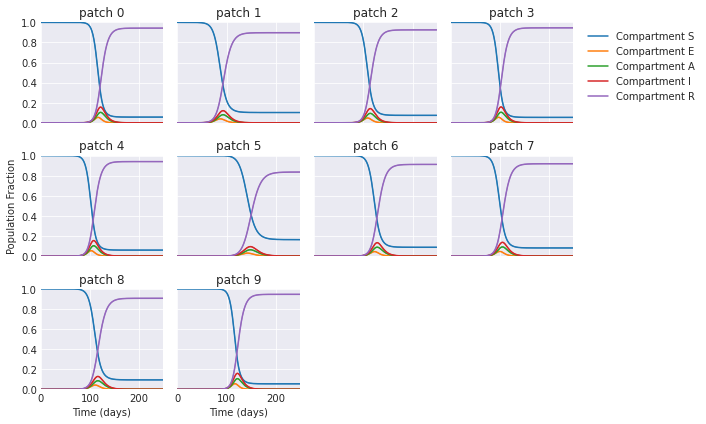

In [4]:
M=10
p = 0.4
graph = py0.gen_random_graph(M,p, seed=0)
py0.draw_graph(graph, dpi =100)
py0.graph_degree(graph)
ref_traj = gen_ref_traj(graph, timesteps=250, population=population,
                          area=area, true_node=true_node)
py0.patch_quantile(ref_traj,patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])
# plt.savefig('p_0.4_graph.png', dpi=600)

In [5]:
def gen_restraints(ref_traj, prior=None, start=None, end=None, marker_color='C0', marker_size=10):
    if prior:
        prior = maxent.Laplace(1)
    else:
        prior = maxent.EmptyPrior()
    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = py0.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.05,
                                                            start_time=start, end_time=end, marker_size=marker_size, marker_color=marker_color)
    plt.figure()
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observations in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches

In [6]:
def gen_samples(graph, mobility_matrix=dense_mobility_matrix, timesteps =250, area = area, populations = population):
    # sparsify mobility matrix for sparse graphs
    sparsed_mobility_matrix = py0.sparse_graph_mobility(graph, mobility_matrix)
#     sparsed_mobility_matrix_norm = sparsed_mobility_matrix / np.sum(sparsed_mobility_matrix, axis=1, keepdims=True)
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 2) # call this alpha
    tmat.add_transition('E', 'I', 2, 2) # call this gamma
    tmat.add_transition('A', 'R',6, 2) # mu
    tmat.add_transition('I', 'R', 6, 2)
    hyper_pram = py0.ParameterHypers()
    hyper_pram.beta_low = [0.005]*2
    hyper_pram.beta_high = [0.08]*2
    hyper_pram.beta_var = [0.1]*2
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 1e-7
    start_logits = np.zeros((M))
    param_model = py0.MetaParameterJoint(start_logits, sparsed_mobility_matrix , tmat, name='unbiased_model',
                                              hypers = hyper_pram, n_infectious_compartments=2)
    import tqdm
    N = 512
    batches = 16
    total_batches = N * batches
    outs = []
    infect = py0.contact_infection_func(infections_compartments, area = area)
    model = py0.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    return trajs, prior_prams
trajs, prior_prams = gen_samples(graph, timesteps =250, area = area, populations = population)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


100%|██████████| 16/16 [00:36<00:00,  2.26s/it]


Plotting 10 patches in a 3 x 4 grid


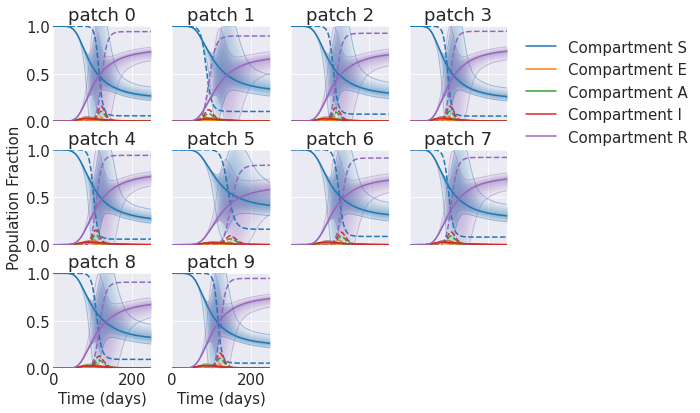

In [26]:
py0.patch_quantile(trajs, ref_traj=ref_traj, patch_names = patches, lower_q_bound=1/3, upper_q_bound=2/3, n_shading_gradients=15,
               figsize=(10, 6), alpha=0.04, names=full_compartments, plot_fxns_list=None,
                   restrained_patches=None, fancy_shading=True)
plt.rcParams['font.size'] = '16'
plt.subplots_adjust(hspace = .3)
plt.savefig('p_0.4_sample_traj.svg', dpi=600, bbox_inches='tight')

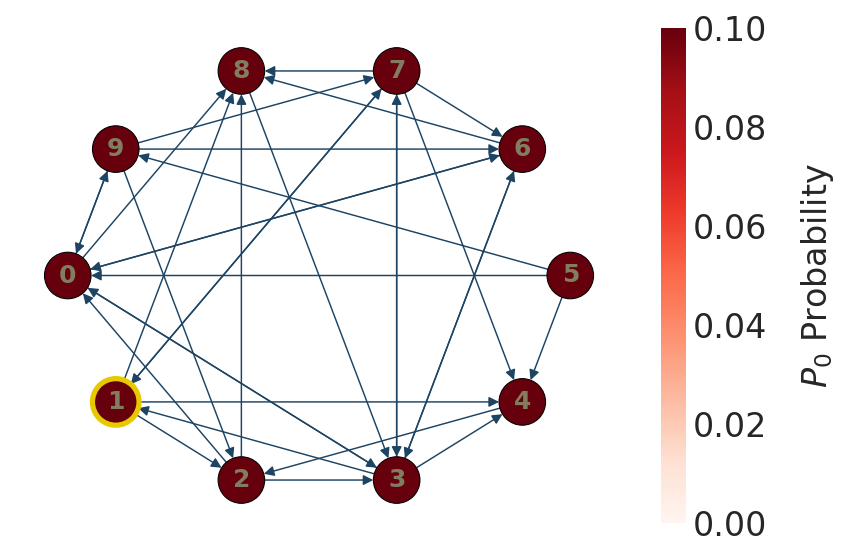

In [10]:
py0.draw_graph(graph, weights=None, heatmap=True, true_origin=true_node)
plt.rcParams['font.size'] = '16'
plt.tight_layout()
plt.savefig('p_0.4_p0_prior.svg', dpi=600)

Restraints are set in this time range: [50, 140]
115 0.12495463 0.12518725548223025
94 0.018101484 0.019280569271552882
80 0.0020643226 0.0020901163443070568
66 0.00020585931 0.00019921141506698556
129 0.06968553 0.07132731090356506
59 8.0972866e-05 7.936108803514211e-05
94 0.025971796 0.025197429024823748
66 0.00026646306 0.0002657626971055206
122 0.5684295 0.5133975986998592
52 2.4147283e-05 2.437520710921492e-05
136 0.011668986 0.010514136201833404
108 0.12939529 0.13227681917209072
129 0.024679562 0.024438525047154398
101 0.12197824 0.12074188823076225
122 0.049851775 0.05039862048101061
59 0.00034798394 0.00033005998279118253
52 0.000100672 0.00010414426627578579
122 0.79896814 0.8509748191005034
87 0.040125556 0.03886543815367363
108 0.4881514 0.47641069818480947
136 0.06088034 0.06163723486635438
52 9.222261e-08 8.87424532483461e-08
108 0.0027116963 0.002942113403670405
59 3.6464965e-07 3.574889055029746e-07
80 2.0437034e-05 1.9555691368607826e-05
94 0.0003224204 0.0003398707066

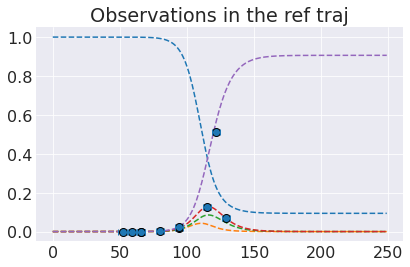

In [11]:
npoints = 5
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
restraints, plot_fxns_list, restrained_patches = gen_restraints(ref_traj, prior=True, start=50, end=140, marker_size=8)
print(restrained_patches)

<AxesSubplot:ylabel='Count'>

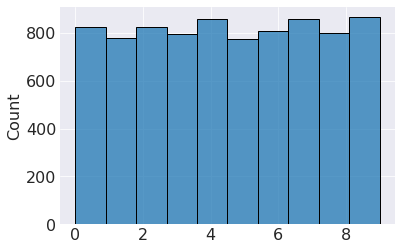

In [12]:
prior_exposed_patch = py0.exposed_finder(trajs)
sns.histplot(x=prior_exposed_patch, label='Prior',
            color='C0',bins=M)

In [17]:
def maxent_fit(trajs, restraints):
    me_model = maxent.MaxentModel(restraints)
    from tensorflow import keras
    optimizer=keras.optimizers.Adam(lr=1e-2) 
    me_model.compile(optimizer=optimizer, loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                              patience=10, min_lr=0)
    me_history = me_model.fit(trajs, batch_size=trajs.shape[0], epochs=1000, callbacks=[reduce_lr])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].plot(me_history.history['loss'])
    ax[0].set_yscale('log')
    ax[0].set_title('loss')
#     ax[1].show()
    ax[1].plot(me_history.history['weight-entropy'])
    ax[1].set_title('weight-entropy')
    return me_model

Epoch 1/1000
1/1 [==============================] - 0s 436ms/step - loss: 55.8306 - weight-entropy: 2.2805
Epoch 2/1000
1/1 [==============================] - 0s 11ms/step - loss: 54.8652 - weight-entropy: 2.4249
Epoch 3/1000
1/1 [==============================] - 0s 5ms/step - loss: 53.7232 - weight-entropy: 2.5959
Epoch 4/1000
1/1 [==============================] - 0s 5ms/step - loss: 52.3247 - weight-entropy: 2.7995
Epoch 5/1000
1/1 [==============================] - 0s 4ms/step - loss: 50.5724 - weight-entropy: 3.0363
Epoch 6/1000
1/1 [==============================] - 0s 5ms/step - loss: 48.3729 - weight-entropy: 3.3000
Epoch 7/1000
1/1 [==============================] - 0s 4ms/step - loss: 45.6706 - weight-entropy: 3.5728
Epoch 8/1000
1/1 [==============================] - 0s 4ms/step - loss: 42.4949 - weight-entropy: 3.8299
Epoch 9/1000
1/1 [==============================] - 0s 4ms/step - loss: 38.9422 - weight-entropy: 4.0532
Epoch 10/1000
1/1 [==============================] -

Epoch 79/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.3278 - weight-entropy: 2.3820
Epoch 80/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.3129 - weight-entropy: 2.4091
Epoch 81/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.2286 - weight-entropy: 2.5543
Epoch 82/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1839 - weight-entropy: 2.7598
Epoch 83/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.2097 - weight-entropy: 2.9104
Epoch 84/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1519 - weight-entropy: 2.9335
Epoch 85/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0701 - weight-entropy: 2.8756
Epoch 86/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0433 - weight-entropy: 2.8217
Epoch 87/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0192 - weight-entropy: 2.8321
Epoch 88/1000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 3ms/step - loss: 0.5379 - weight-entropy: 4.3203
Epoch 234/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5357 - weight-entropy: 4.3235
Epoch 235/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5335 - weight-entropy: 4.3267
Epoch 236/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.5313 - weight-entropy: 4.3299
Epoch 237/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5291 - weight-entropy: 4.3330
Epoch 238/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.5270 - weight-entropy: 4.3361
Epoch 239/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5249 - weight-entropy: 4.3393
Epoch 240/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5227 - weight-entropy: 4.3424
Epoch 241/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5206 - weight-entropy: 4.3455
Epoch 242/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.3245 - weight-entropy: 4.6812
Epoch 388/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3236 - weight-entropy: 4.6830
Epoch 389/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3227 - weight-entropy: 4.6848
Epoch 390/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3218 - weight-entropy: 4.6865
Epoch 391/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3209 - weight-entropy: 4.6883
Epoch 392/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3200 - weight-entropy: 4.6901
Epoch 393/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3191 - weight-entropy: 4.6919
Epoch 394/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3183 - weight-entropy: 4.6937
Epoch 395/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3174 - weight-entropy: 4.6954
Epoch 396/1000
1/1 [==============================] - 0s 4ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.2218 - weight-entropy: 4.9030
Epoch 542/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2213 - weight-entropy: 4.9040
Epoch 543/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2209 - weight-entropy: 4.9051
Epoch 544/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2204 - weight-entropy: 4.9061
Epoch 545/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2199 - weight-entropy: 4.9070
Epoch 546/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2194 - weight-entropy: 4.9080
Epoch 547/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2190 - weight-entropy: 4.9090
Epoch 548/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2185 - weight-entropy: 4.9100
Epoch 549/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2180 - weight-entropy: 4.9110
Epoch 550/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 5ms/step - loss: 0.1648 - weight-entropy: 4.9914
Epoch 696/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1645 - weight-entropy: 4.9916
Epoch 697/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1642 - weight-entropy: 4.9918
Epoch 698/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1639 - weight-entropy: 4.9920
Epoch 699/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1637 - weight-entropy: 4.9922
Epoch 700/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1634 - weight-entropy: 4.9924
Epoch 701/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1631 - weight-entropy: 4.9925
Epoch 702/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1628 - weight-entropy: 4.9927
Epoch 703/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1625 - weight-entropy: 4.9929
Epoch 704/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.1281 - weight-entropy: 4.9900
Epoch 850/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1279 - weight-entropy: 4.9898
Epoch 851/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1277 - weight-entropy: 4.9897
Epoch 852/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1275 - weight-entropy: 4.9895
Epoch 853/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1273 - weight-entropy: 4.9894
Epoch 854/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1271 - weight-entropy: 4.9892
Epoch 855/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1269 - weight-entropy: 4.9891
Epoch 856/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1268 - weight-entropy: 4.9889
Epoch 857/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1266 - weight-entropy: 4.9888
Epoch 858/1000
1/1 [==============================] - 0s 3ms/

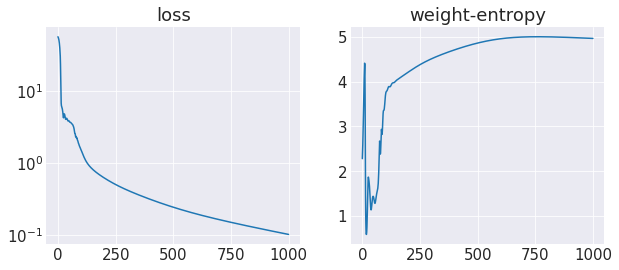

In [18]:
me_model = maxent_fit(trajs, restraints)

Plotting 10 patches in a 3 x 4 grid


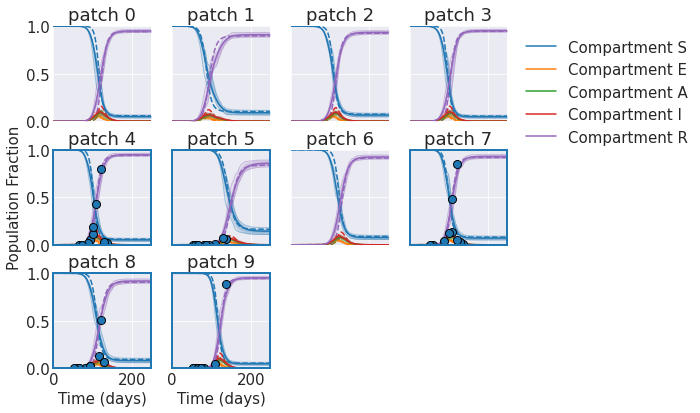

In [19]:
# weights_dict = {'unbiased':None, 'biased':me_model.traj_weights}
# compare_patches(ref_traj, trajs, weights_dict,'biased', restrained_patches, plot_fxns_list,
#                 patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)
py0.patch_quantile(trajs, weights=me_model.traj_weights, ref_traj=ref_traj, patch_names = patches, lower_q_bound=1/3, upper_q_bound=2/3, n_shading_gradients=15,
               figsize=(10, 6), alpha=0.04, names=full_compartments, plot_fxns_list=plot_fxns_list,
                   restrained_patches=restrained_patches, fancy_shading=True)
plt.rcParams['font.size'] = '16'
plt.subplots_adjust(hspace = .3)
# plt.tight_layout()
plt.savefig('p_0.4_posterior.svg', dpi=600, bbox_inches='tight')

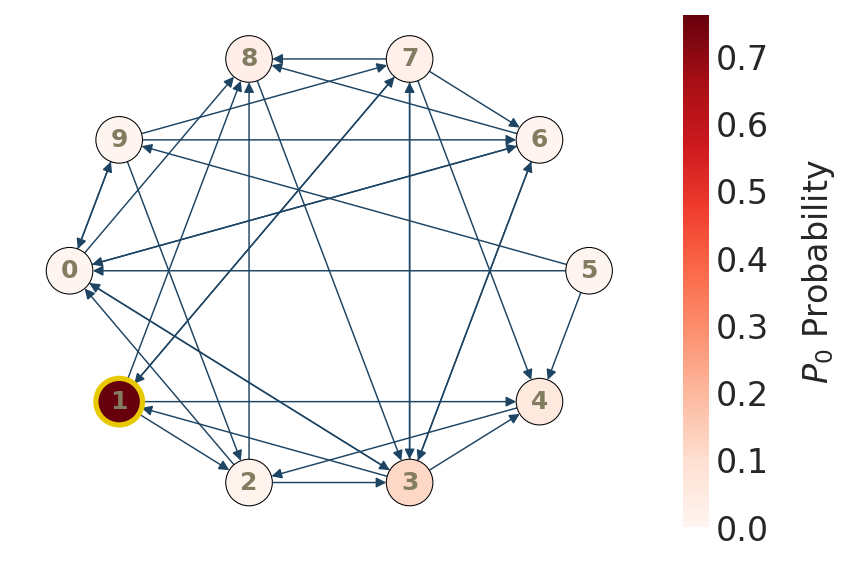

In [20]:
me_w = me_model.traj_weights
exposed_prob = py0.weighted_exposed_prob_finder(
                            prior_exposed_patch, M)
weighted_exposed_prob = py0.weighted_exposed_prob_finder(
                            prior_exposed_patch, M, weights=me_w)
# py0.draw_graph(graph, weights=exposed_prob, title='Prior', heatmap=True, true_origin=true_node)
# fig, ax = plt.subplots()
py0.draw_graph(graph, weights=weighted_exposed_prob, heatmap=True, true_origin=true_node)
plt.rcParams['font.size'] = '15'
plt.tight_layout()
plt.savefig('p_0.4_p0_posterior.svg', dpi=600)

In [21]:
def get_dist(prior_prams):
    R_dist = []
    T_dist = []
    start_dist = []
    beta_dist = []
    for i in range(len(prior_prams)):
        param_batch = prior_prams[i]
#         R_dist.append(param_batch[0])
        T_dist.append(param_batch[1])
        start_dist.append(param_batch[2])
        beta_dist.append(param_batch[3])
#     R_dist = tf.concat(R_dist, axis = 0)
    T_dist = tf.concat(T_dist, axis = 0)
    start_dist = tf.concat(start_dist, axis = 0)
    beta_dist = tf.concat(beta_dist, axis = 0)
    # get eta^-1
    E_A = 1/T_dist[:, compartments.index('E'), compartments.index('A')].numpy()
    # get gamma^-1
    E_I = 1/T_dist[:, compartments.index('E'), compartments.index('I')].numpy()
    # get mu^-1
    A_R = 1/T_dist[:, compartments.index('A'), compartments.index('R')].numpy()
    # get mu^-1
    I_R = 1/T_dist[:, compartments.index('I'), compartments.index('R')].numpy()
    # Getting starting exposed fraction 
    mask = tf.greater(start_dist, 0)
    start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
    return [E_A, E_I,A_R, I_R, start_exposed_dist, beta_dist]

prior_param_dist = get_dist(prior_prams)
E_A, E_I, A_R, I_R, start_exposed_dist, beta_dist = prior_param_dist

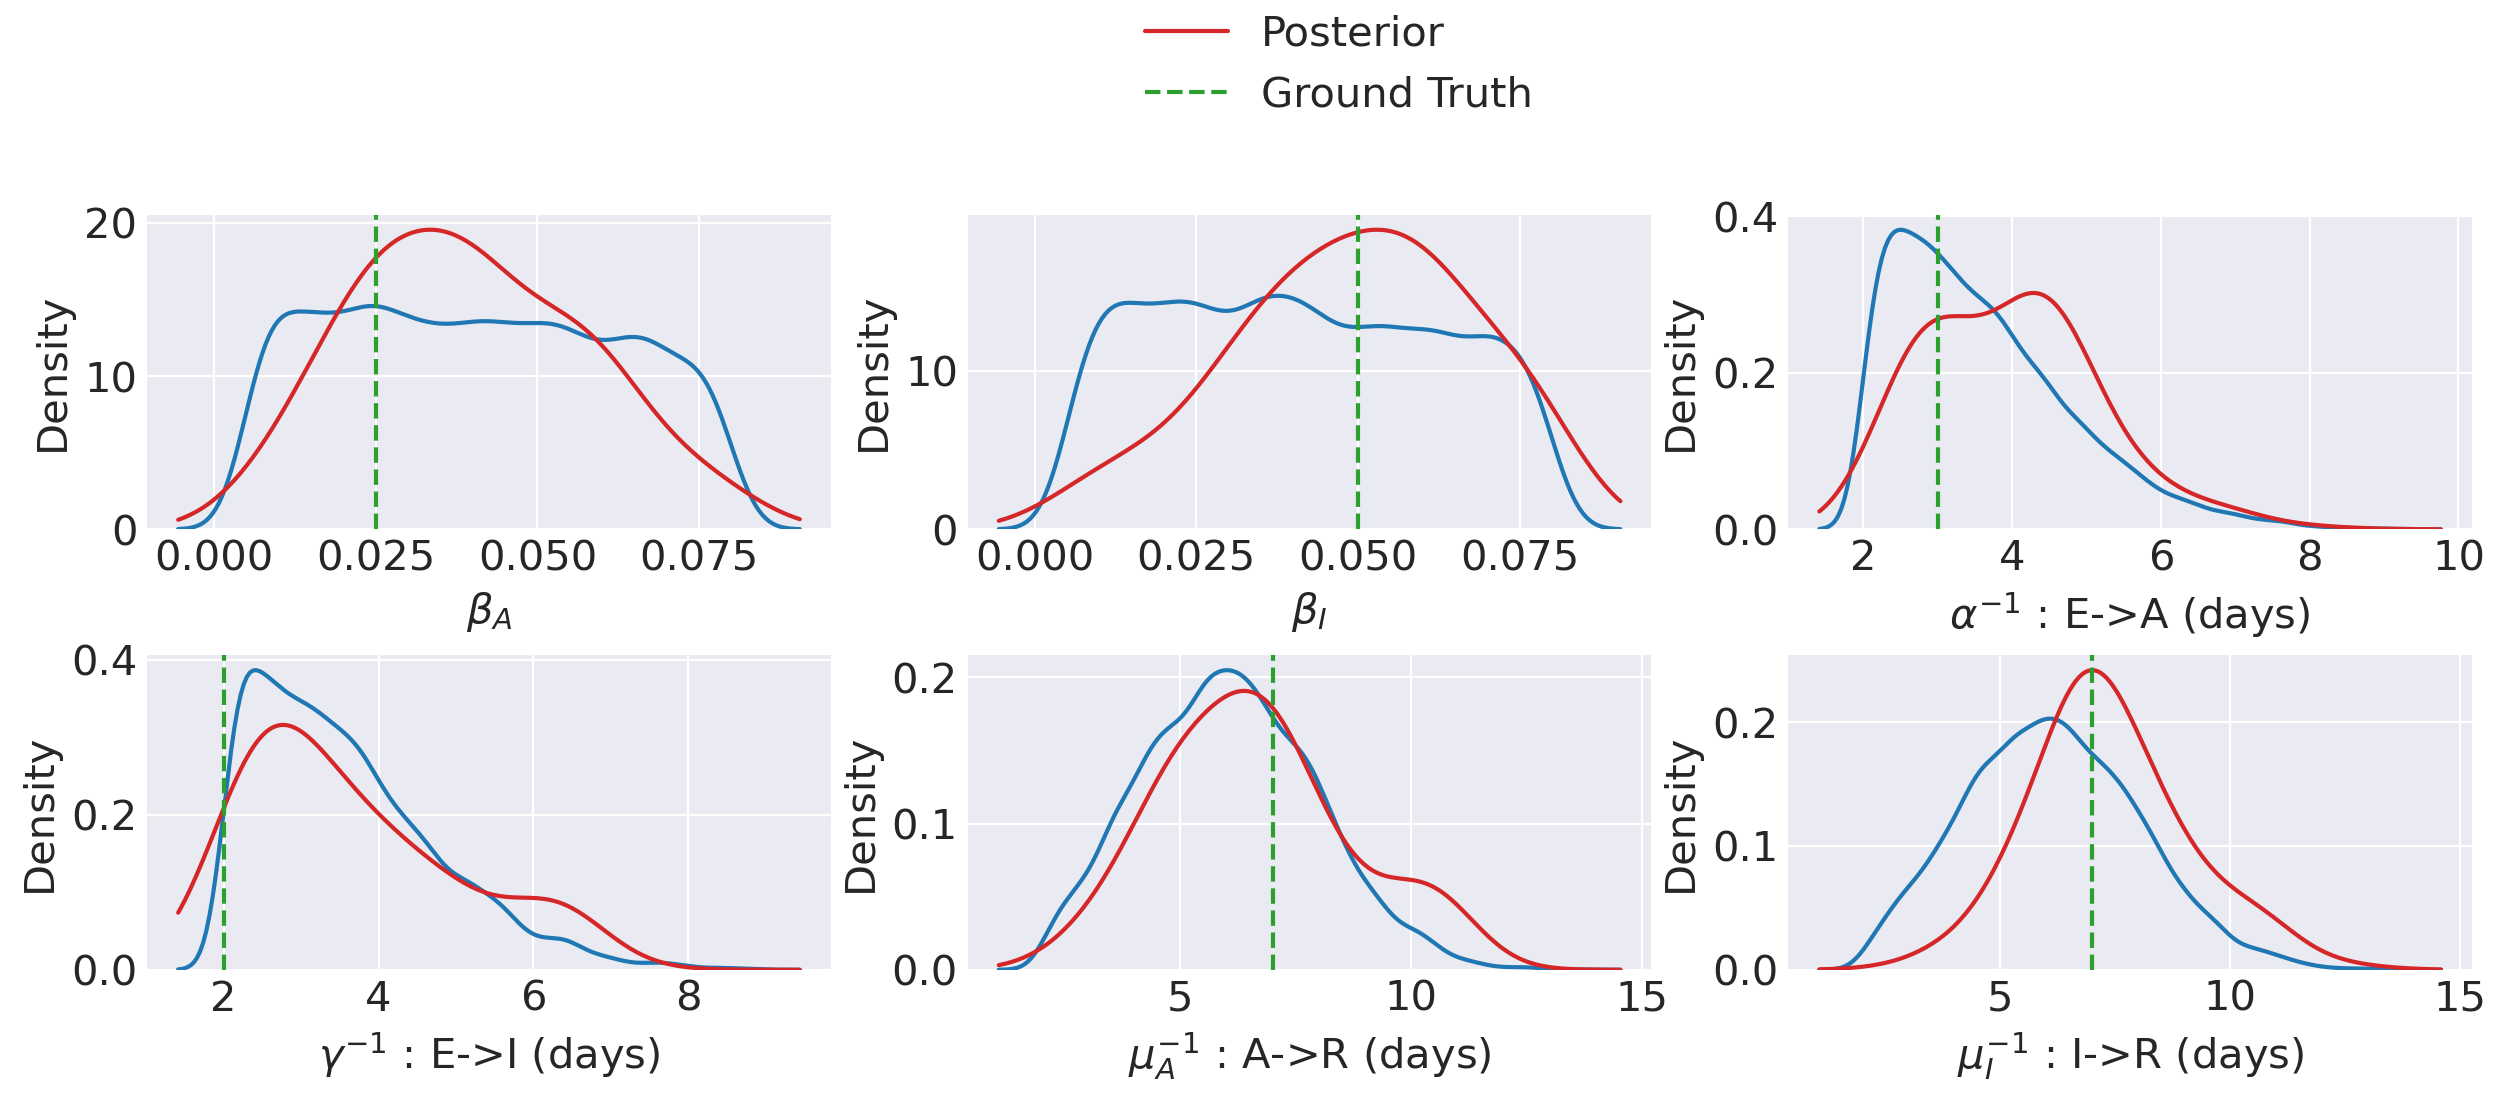

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta_{A}$')
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\beta_{I}$')

# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=np.squeeze(E_A), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\alpha^{-1}$ : E->A (days)')

sns.kdeplot(x=np.squeeze(E_I), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=np.squeeze(E_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\gamma ^{-1}$ : E->I (days)')

sns.kdeplot(x=np.squeeze(A_R), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel(r'$\mu_{A}^{-1}$ : A->R (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,2])
sns.kdeplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2],legend=False)
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')


beta_A = 0.025
beta_I=0.05
alpha =1/3
gamma=1/2
mu=1/7
axs[0,0].axvline(x=beta_A, color='C2', linestyle='--', label= 'Ground Truth')
axs[0,1].axvline(x=beta_I, color='C2', linestyle='--')
axs[0,2].axvline(x=(1/alpha), color='C2', linestyle='--')
axs[1,0].axvline(x=(1/gamma), color='C2', linestyle='--')
axs[1,1].axvline(x=1/mu, color='C2', linestyle='--')
axs[1,2].axvline(x=1/mu, color='C2', linestyle='--')
handles, labels = axs[0,0].get_legend_handles_labels()
# axs[1,2].get_legend().set_visible(False)
fig.legend(handles, labels, loc=(0.45,0.88))
plt.subplots_adjust(hspace=0.4)
plt.savefig('parameter_dist.svg', dpi=300)

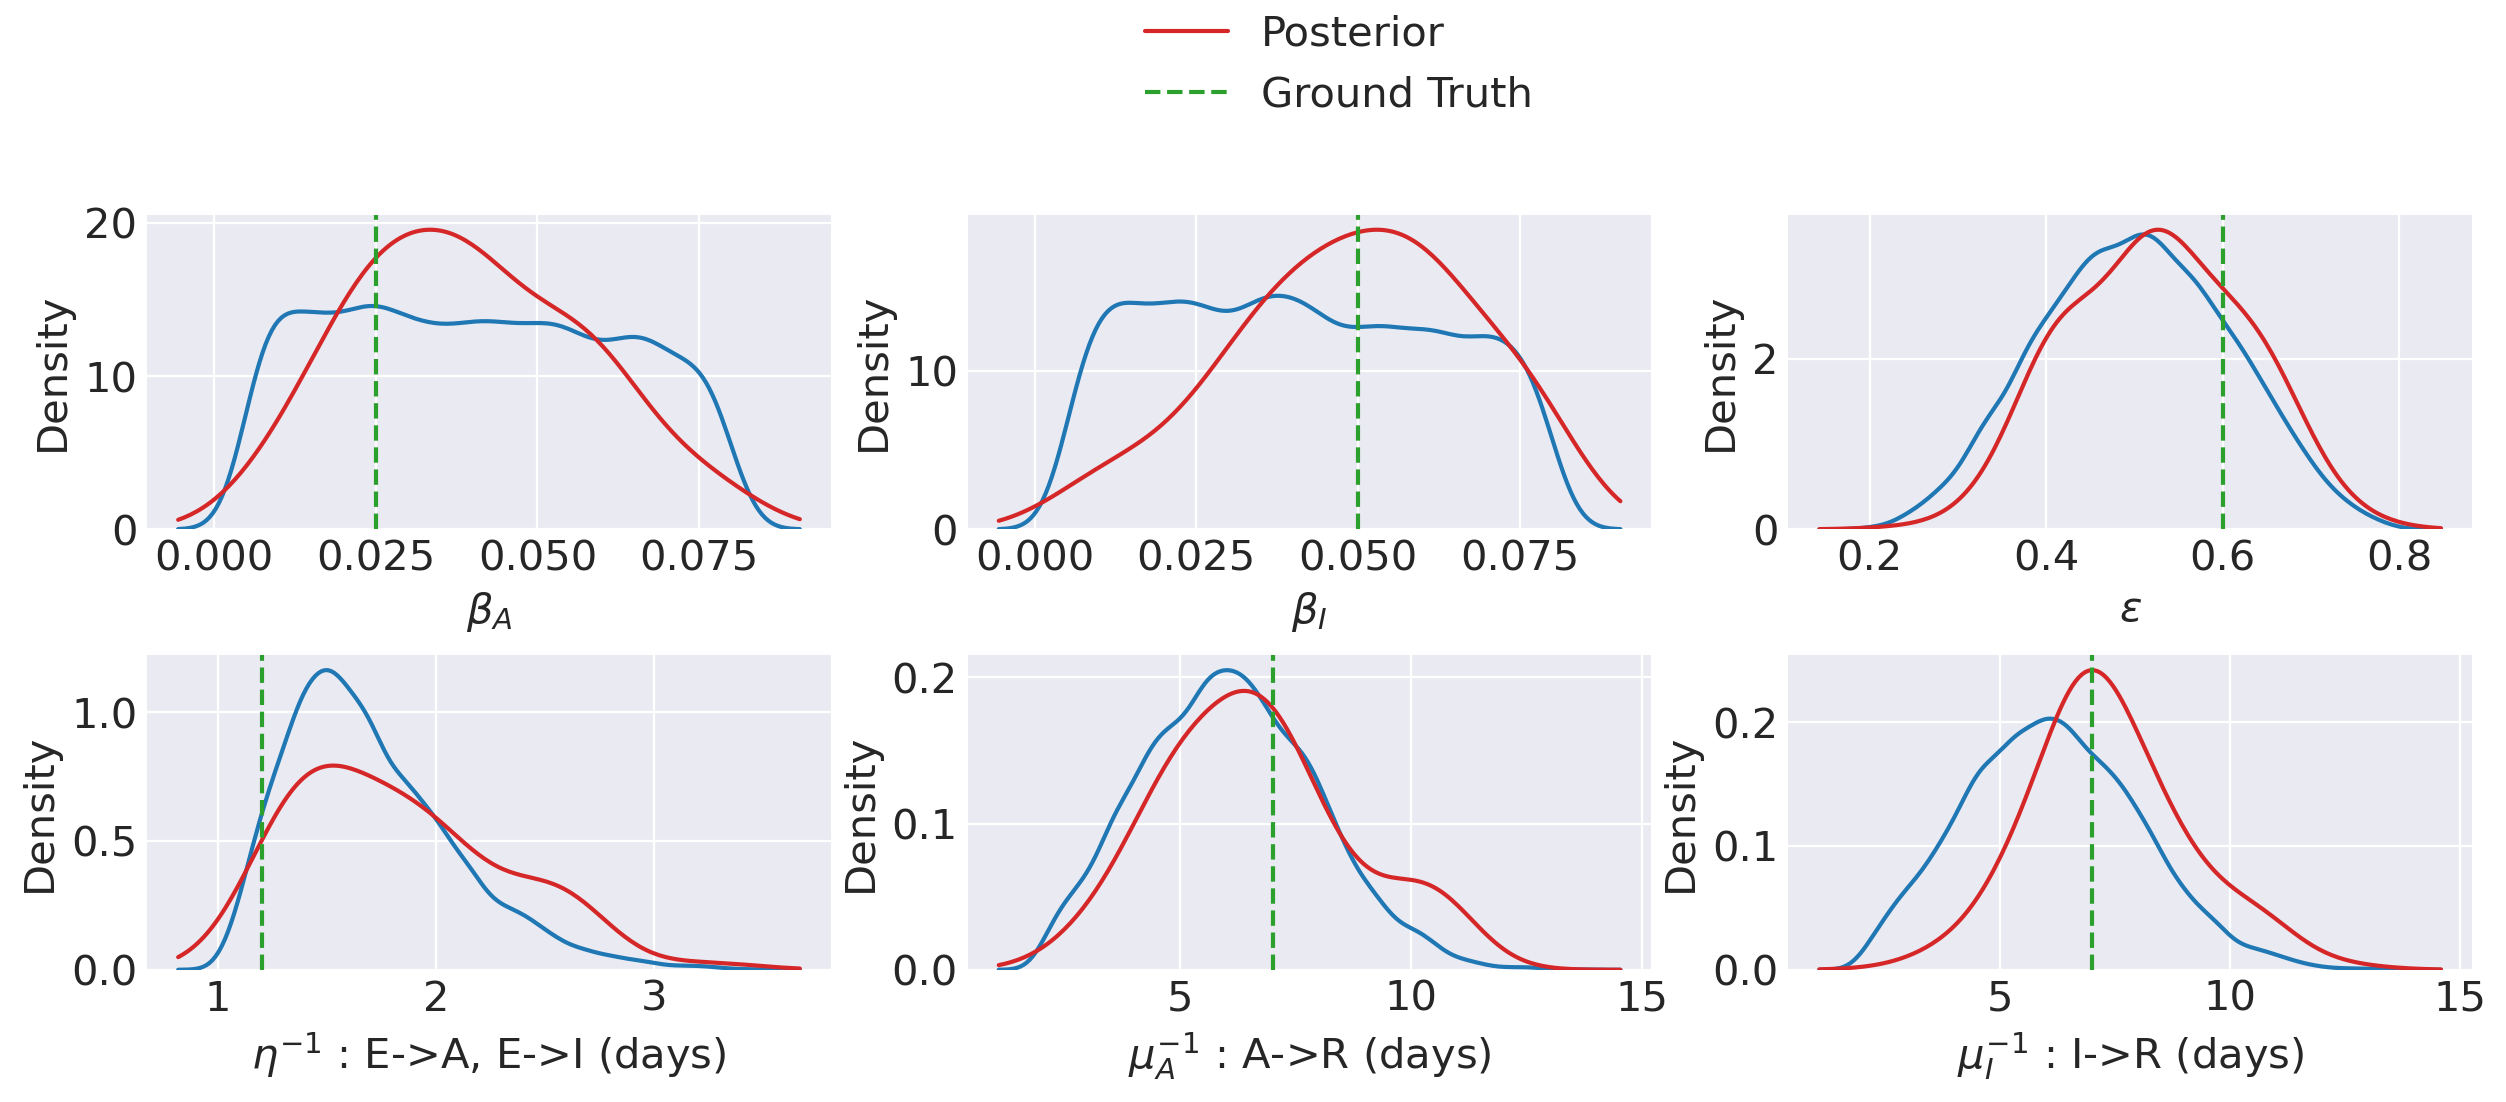

In [23]:
# eta = alpha + gamma
# epsilon = gamma/(alpha+gamma)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta_{A}$')
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\beta_{I}$')

# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=1/np.squeeze(E_I)/(1/np.squeeze(E_I)+ 1/np.squeeze(E_A)), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=1/np.squeeze(E_I)/(1/np.squeeze(E_I)+ 1/np.squeeze(E_A)), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\epsilon$')

sns.kdeplot(x=1/(1/np.squeeze(E_I)+ 1/np.squeeze(E_A)), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=1/(1/np.squeeze(E_I)+ 1/np.squeeze(E_A)) , weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\eta ^{-1}$ : E->A, E->I (days)')

sns.kdeplot(x=np.squeeze(A_R), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel(r'$\mu_{A}^{-1}$ : A->R (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,2])
sns.kdeplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2],legend=False)
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')


beta_A = 0.025
beta_I=0.05
alpha =1/3
gamma=1/2
mu=1/7
axs[0,0].axvline(x=beta_A, color='C2', linestyle='--', label= 'Ground Truth')
axs[0,1].axvline(x=beta_I, color='C2', linestyle='--')
axs[0,2].axvline(x=gamma/(alpha+gamma), color='C2', linestyle='--')
axs[1,0].axvline(x=1/(alpha+gamma), color='C2', linestyle='--')
axs[1,1].axvline(x=1/mu, color='C2', linestyle='--')
axs[1,2].axvline(x=1/mu, color='C2', linestyle='--')
handles, labels = axs[0,0].get_legend_handles_labels()
# axs[1,2].get_legend().set_visible(False)
fig.legend(handles, labels, loc=(0.45,0.88))
plt.subplots_adjust(hspace=0.4)
plt.savefig('parameter_dist_with_epsilon_eta.svg', dpi=300)

In [25]:
traj_loss = py0.traj_loss(ref_traj, trajs, me_w)
p0_loss = py0.p0_loss(trajs,me_w, true_node)
# posterior_exposed_prob = py0.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print(f'P0 cross-entropy : {p0_loss:.3f}, Traj KL : {traj_loss:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob, patches), reverse=True)[:5])

P0 cross-entropy : 0.272, Traj KL : 0.008
Top 5 posterior probabilities for P0: 
 [(0.7621855620485555, 'patch 1'), (0.1177890751650025, 'patch 3'), (0.05371049567830619, 'patch 4'), (0.029433691974148468, 'patch 8'), (0.02310656179114414, 'patch 7')]


In [2]:
run_doe = False
dat=[]
if run_doe:
    for i,p in enumerate(connecting_probability):
        M=10
        true_node = np.random.randint(M)
        graph = py0.gen_random_graph(M,p)
        ref_traj = gen_ref_traj(graph, timesteps=250, population=population,
                                  area=area, true_node=true_node)
        trajs = gen_samples(graph, timesteps =250, area = area, populations = population)
        npoints = 5
        number_of_restrained_patches = 5
        restrained_compartments = [3,4] #(infected patch and recovered)
        number_of_restrained_compartments = len(restrained_compartments) 
        restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
        restrained_compartments_names = " ".join(restrained_compartments_names)
    #     plt.figure()
        restraints, plot_fxns_list, restrained_patches = gen_restraints(ref_traj, prior=True, start=50, end=140)
        prior_exposed_patch = py0.exposed_finder(trajs)
        me_model = maxent_fit(trajs, restraints)
        weights_dict = {'unbiased':None, 'biased':me_model.traj_weights}
        me_w = me_model.traj_weights
        exposed_prob = py0.weighted_exposed_prob_finder(
                                    prior_exposed_patch, M)
        weighted_exposed_prob = py0.weighted_exposed_prob_finder(
                                    prior_exposed_patch, M, weights=me_w)
        traj_loss = py0.traj_loss(ref_traj, trajs, me_w).numpy()
        p0_loss = py0.p0_loss(trajs,me_w, true_node)
        compare_patches(ref_traj, trajs, weights_dict,'biased', restrained_patches, plot_fxns_list,
                    patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)
        fig, ax = plt.subplots()
        py0.draw_graph(graph, weights=weighted_exposed_prob, title=f'Posterior - P = {p:.3f}', heatmap=True, true_origin=true_node)
        print(f'P0 cross-entropy : {p0_loss:.3f}, Traj KL : {traj_loss:.3f}')
        print(f'Iteration: {i}, p: {p}, True_node: {true_node}'
              '\nTop 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob, patches), reverse=True)[:5])
        p0_pred = sorted(zip(weighted_exposed_prob, patches), reverse=True)[:1][0]
        certainty = p0_pred[0]
        predcited_node = int(p0_pred[1].split()[1])
        if predcited_node == true_node:
            prediction = True
        else:
            prediction = False
        dat.append([traj_loss, p0_loss, certainty, prediction, true_node, predcited_node])
    with open('data.npz', 'wb') as f:
        np.save(f, dat)
else:
#     results = np.load('../examples/data.npz')
    dat = np.load('../examples/shifts_p_data/zipped/p_shifts_lr_0.1_top1.npz')
#     for f in results.files:
#         dat.append(results[f].astype(float))
# dat = np.array(dat)

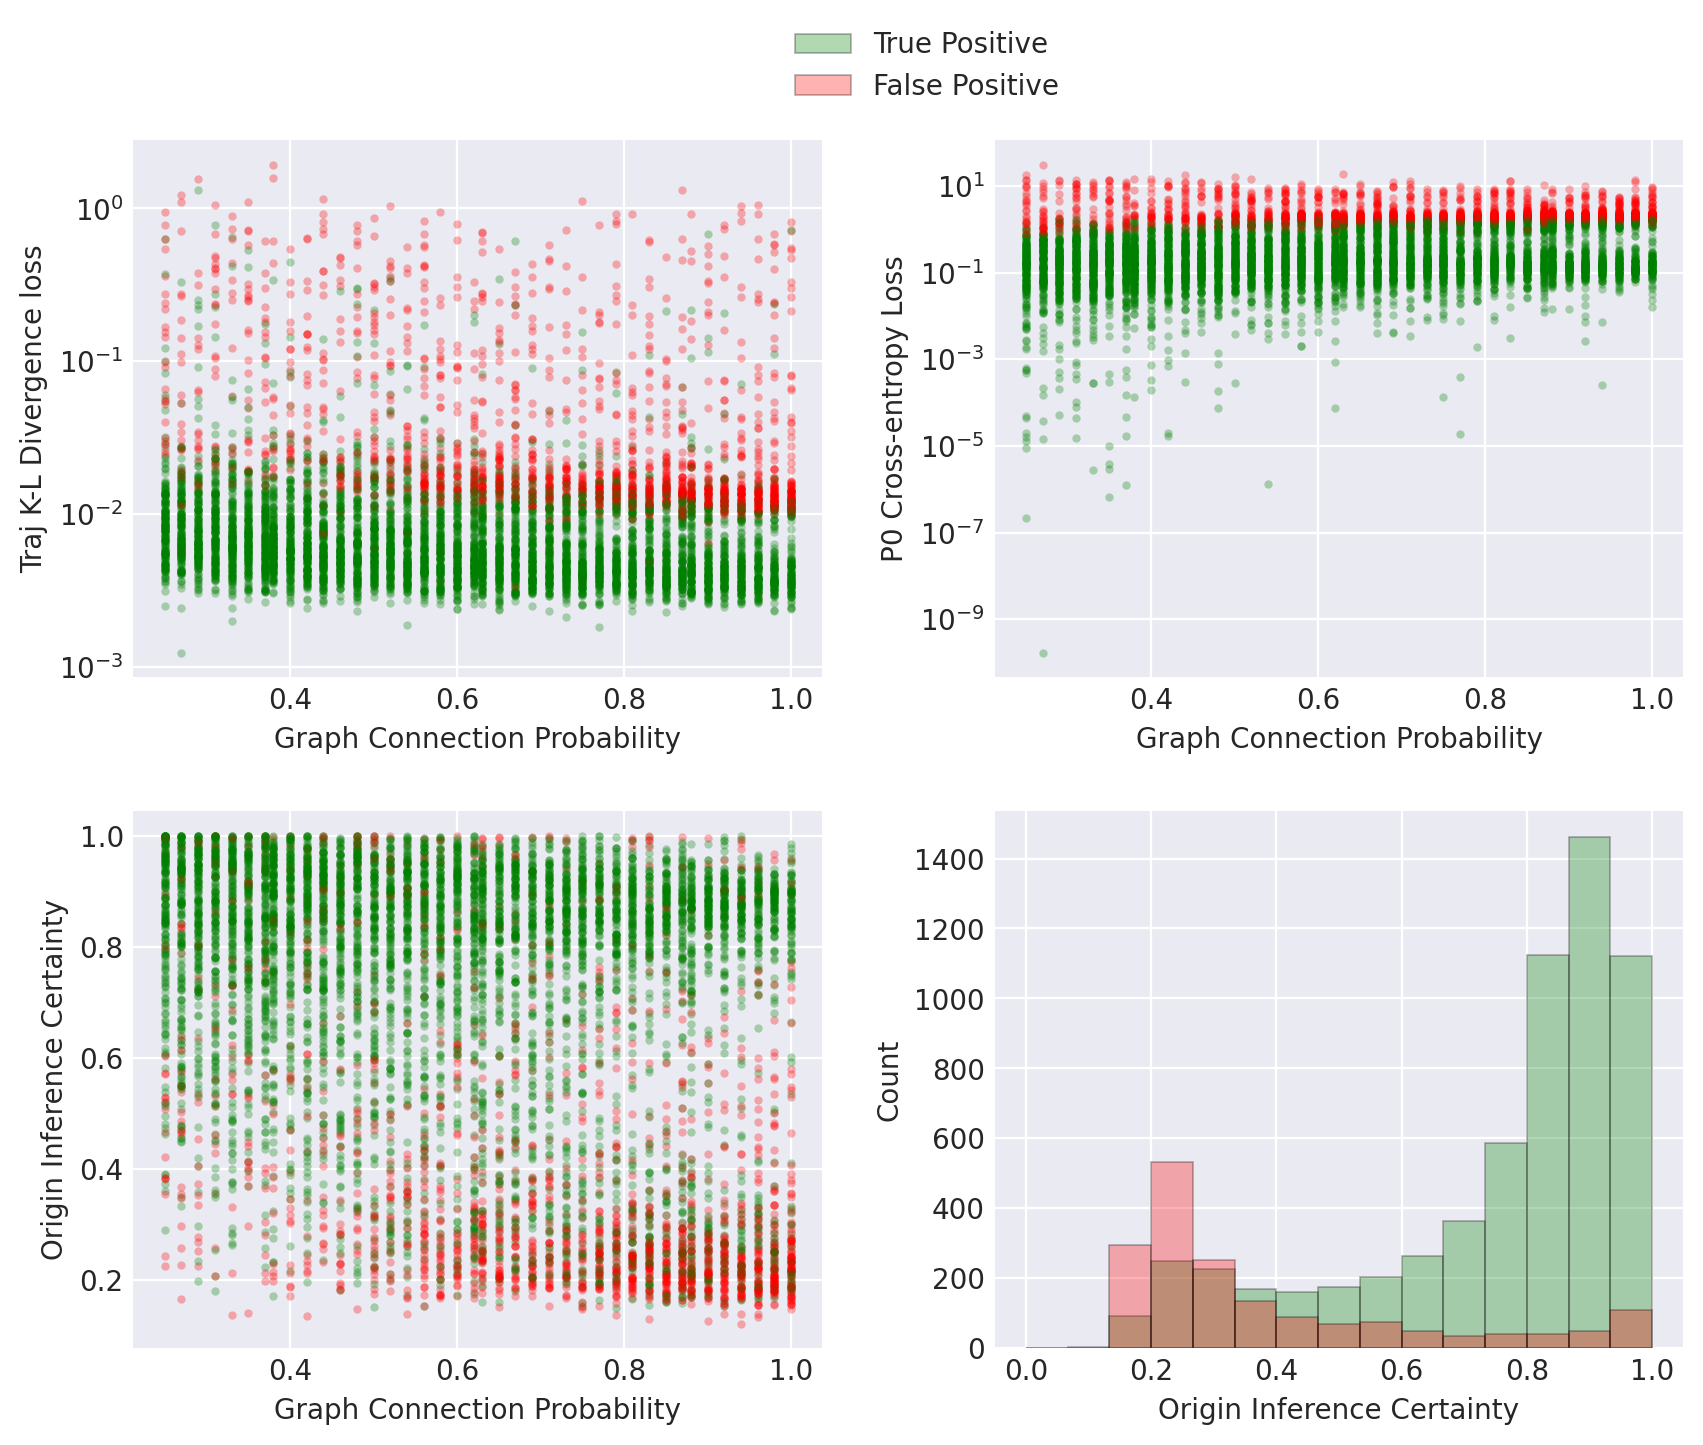

In [3]:
connecting_probabilities, traj_losses, p0_losses  = dat[:, 0], dat[:, 1], dat[:, 2]
certainties, predictions, true_nodes, predicted_nodes, model_fit_losses  = dat[:, 3], dat[:, 4].astype(bool), dat[:, 5], dat[:, 6], dat[:, 7]
marker_colors = []
alpha = 0.3
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probabilities)):
    if predictions[i]:
        marker_colors.append('g')
    else:
        marker_colors.append('r')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8), dpi=200)
ax[0,0].set_xlabel('Graph Connection Probability')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability')
ax[0,1].set_ylabel('P0 Cross-entropy Loss')
ax[0,1].set_yscale('log')
ax[1,0].set_xlabel('Graph Connection Probability')
ax[1,0].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
for i, mc in enumerate(marker_colors):
    ax[0,0].plot(connecting_probabilities[i], traj_losses[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[0,1].plot(connecting_probabilities[i], p0_losses[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[1,0].plot(connecting_probabilities[i], certainties[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
    else:
        fps.append(certainties[i])
bins = np.linspace(0,1,16)
counts_t, bins_t, bars_t = ax[1,1].hist(tps, bins, alpha=alpha, label='True Positive', color='g', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,1].hist(fps, bins, alpha=alpha, label='False Positive', color='r', rwidth=1, edgecolor='k', linewidth=0.6)
ax[1,1].set_xlabel('Origin Inference Certainty')
ax[1,1].set_ylabel('Count')
fig.subplots_adjust(hspace=0.25, wspace=0.25)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.38, 1.25))
bins_t = bins_t[1:]

Text(0, 0.5, 'Accuracy')

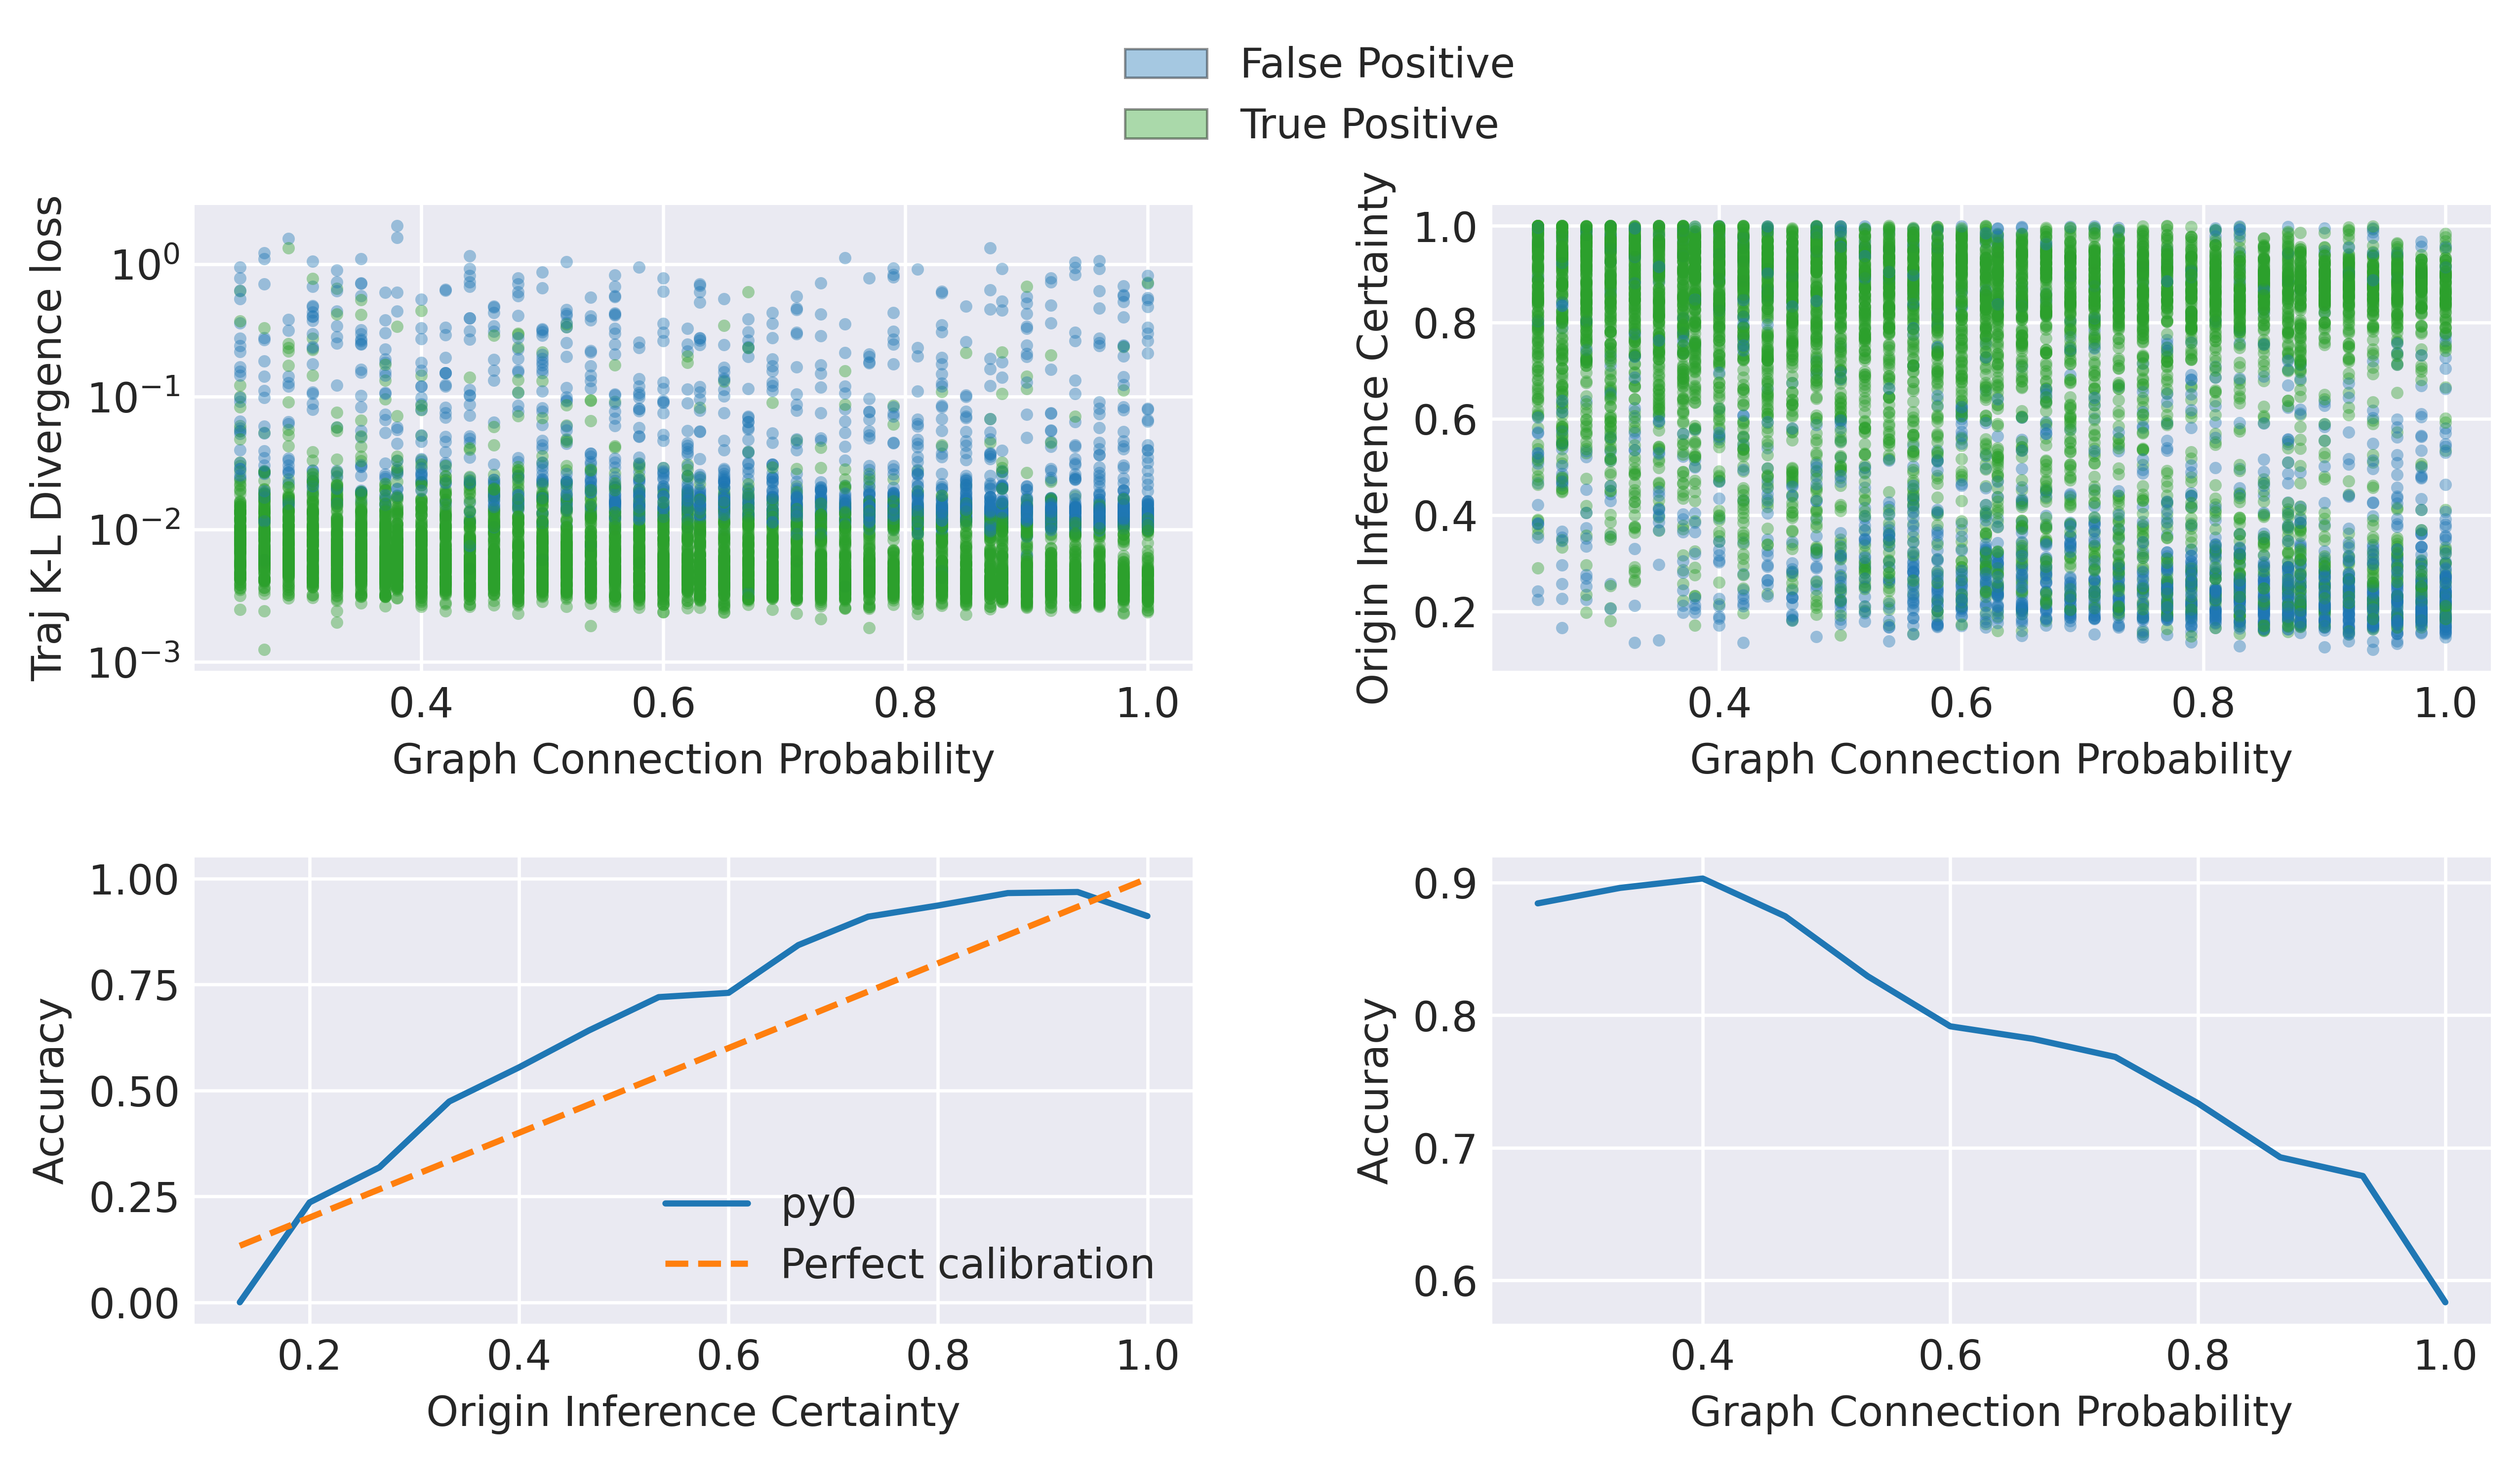

In [4]:
connecting_probabilities, traj_losses, p0_losses  = dat[:, 0], dat[:, 1], dat[:, 2]
certainties, predictions, true_nodes, predicted_nodes, model_fit_losses  = dat[:, 3], dat[:, 4].astype(bool), dat[:, 5], dat[:, 6], dat[:, 7]
marker_colors = []
alpha = 0.4
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probabilities)):
    if predictions[i]:
        marker_colors.append('C2')
    else:
        marker_colors.append('C0')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), dpi=600)
ax[0,0].set_xlabel('Graph Connection Probability')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability')
ax[0,1].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
fps_p_node = []
tps_p_node = []
for i, mc in enumerate(marker_colors):
    ax[0,0].plot(connecting_probabilities[i], traj_losses[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[0,1].plot(connecting_probabilities[i], certainties[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
        tps_p_node.append(connecting_probabilities[i])
    else:
        fps.append(certainties[i])
        fps_p_node.append(connecting_probabilities[i])
bins = np.linspace(0,1,16)
counts_t, bins_t, bars_t = ax[1,0].hist(tps, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,0].hist(fps, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.4, wspace=0.3)


bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[1,0].clear()
ax[1,0].plot(bins_t, accuracy, label='py0')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[1,0].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
ax[1,0].set_xlabel('Origin Inference Certainty')
ax[1,0].set_ylabel('Accuracy')
legend = ax[1,0].legend()
bins_p_node = np.unique(connecting_probabilities)
counts_f_p_node, bins_f_p_node, bars_f_p_node = ax[1,1].hist(fps_p_node, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
counts_t_p_node, bins_t_p_node, bars_t_p_node = ax[1,1].hist(tps_p_node, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.36, 1.42))
ax[1,1].clear()
accuracy_p_node = counts_t_p_node/(counts_f_p_node + counts_t_p_node)
non_nan_p_node = np.min(np.where(np.isfinite(accuracy_p_node)))
ax[1,1].plot(bins_t,accuracy_p_node, label='Maxent')
ax[1,1].set_xlabel('Graph Connection Probability')
ax[1,1].set_ylabel('Accuracy')
# plt.tight_layout()
# plt.savefig('adjust_p_grah.png', dpi=600)

In [5]:
connecting_probabilities, traj_losses, p0_losses  = dat[:, 0], dat[:, 1], dat[:, 2]
certainties, predictions, true_nodes, predicted_nodes, model_fit_losses  = dat[:, 3], dat[:, 4].astype(bool), dat[:, 5], dat[:, 6], dat[:, 7]
min_q = 0.25 
max_q = 0.75
p_values = np.round(np.linspace(0.25, 1, 40), 2)
box_traj_loss_T = []
box_traj_loss_F = []
box_certainty_T = []
box_certainty_F = []
for j, p in enumerate(p_values):
    quant_traj_loss_T = []
    quant_traj_loss_F = []
    quant_certainty_T = []
    quant_certainty_F = []
    for i, d in enumerate(dat):
        if d[0] == p:
            if d[4]:
                quant_traj_loss_T.append(traj_losses[i])
                quant_certainty_T.append(certainties[i])
            else:
                quant_traj_loss_F.append(traj_losses[i])
                quant_certainty_F.append(certainties[i])
    box_traj_loss_T.append(np.quantile(np.array(quant_traj_loss_T),[min_q,0.5,max_q]))
    box_traj_loss_F.append(np.quantile(np.array(quant_traj_loss_F),[min_q,0.5,max_q]))
    box_certainty_T.append(np.quantile(np.array(quant_certainty_T),[min_q,0.5,max_q]))
    box_certainty_F.append(np.quantile(np.array(quant_certainty_F),[min_q,0.5,max_q]))
box_traj_loss_T = np.array(box_traj_loss_T)
box_traj_loss_F = np.array(box_traj_loss_F)
box_certainty_T = np.array(box_certainty_T)
box_certainty_F = np.array(box_certainty_F)

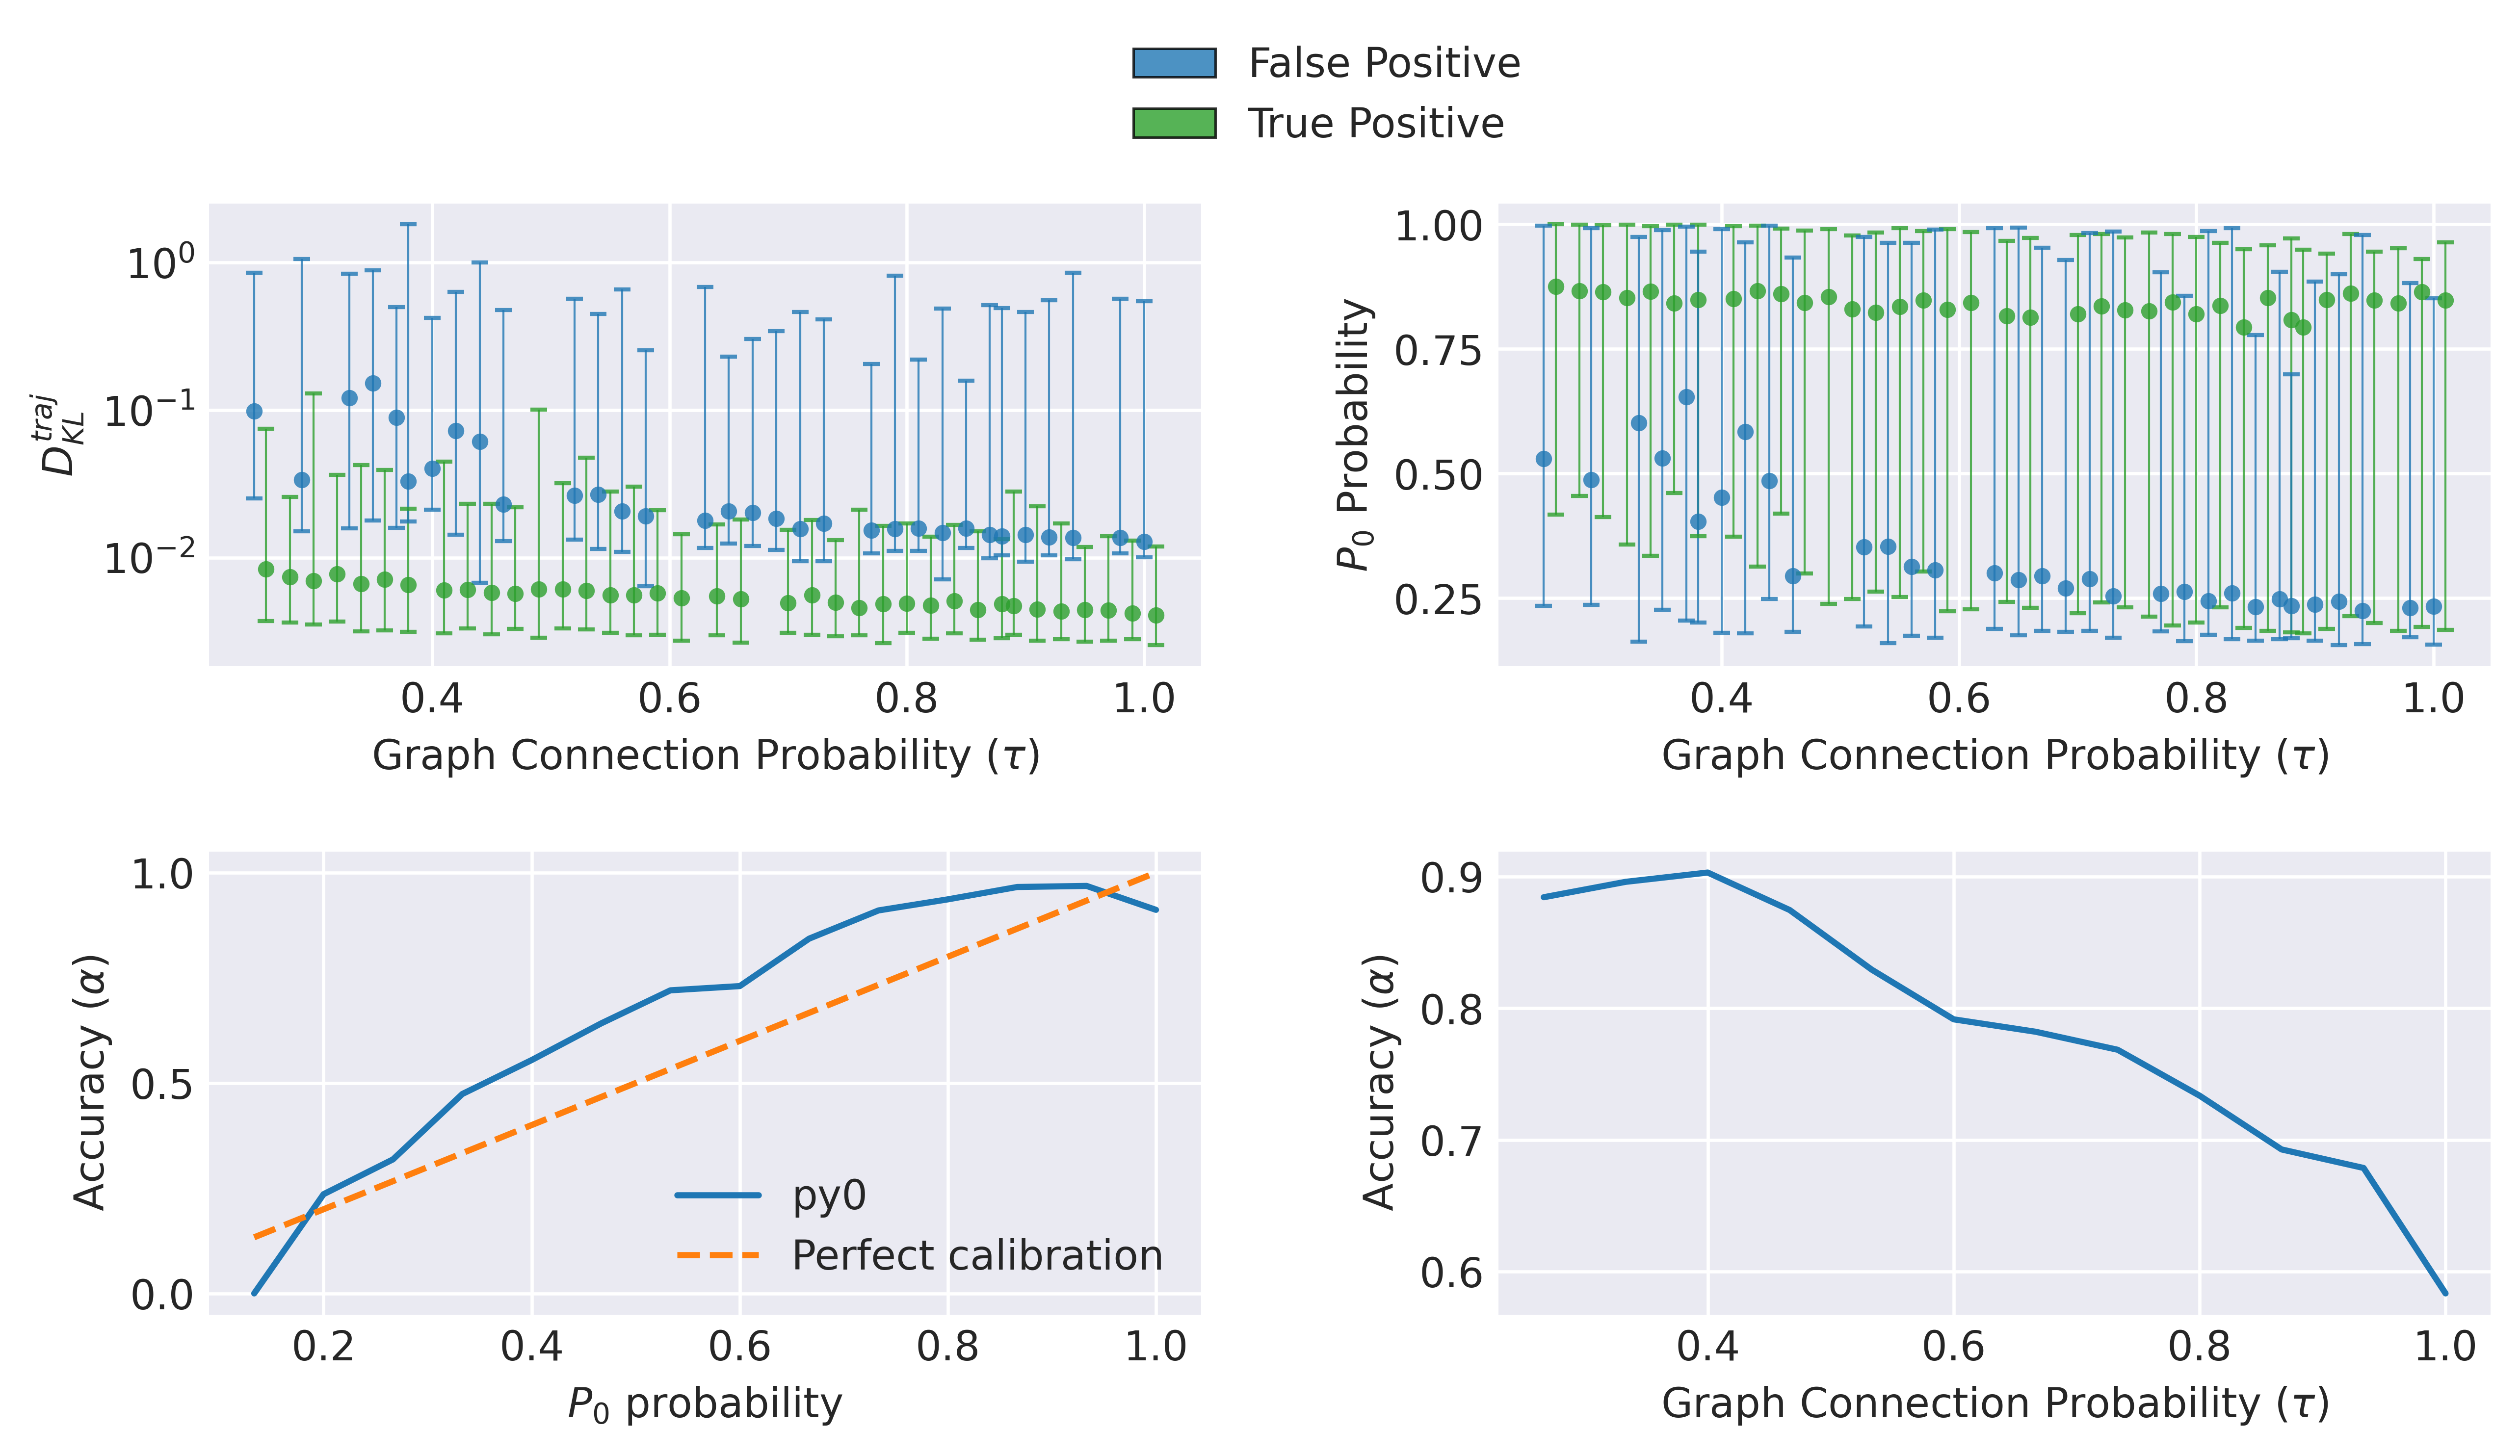

In [6]:
# revised figure with error bars
connecting_probabilities, traj_losses, p0_losses  = dat[:, 0], dat[:, 1], dat[:, 2]
certainties, predictions, true_nodes, predicted_nodes, model_fit_losses  = dat[:, 3], dat[:, 4].astype(bool), dat[:, 5], dat[:, 6], dat[:, 7]
marker_colors = []
alpha = 0.8
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probabilities)):
    if predictions[i]:
        marker_colors.append('C2')
    else:
        marker_colors.append('C0')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), dpi=600)
ax[0,0].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[0,0].set_ylabel('$D_{KL} ^{traj}$')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[0,1].set_ylabel('$P_0$ Probability')
fps = []
tps = []
fps_p_node = []
tps_p_node = []

min_q = 0.025 
max_q = 0.975
p_values = np.round(np.linspace(0.25, 1, 40), 2)
box_traj_loss_T = []
box_traj_loss_F = []
box_certainty_T = []
box_certainty_F = []
for j, p in enumerate(p_values):
    quant_traj_loss_T = []
    quant_traj_loss_F = []
    quant_certainty_T = []
    quant_certainty_F = []
    for i, d in enumerate(dat):
        if d[0] == p:
            if d[4]:
                quant_traj_loss_T.append(traj_losses[i])
                quant_certainty_T.append(certainties[i])
            else:
                quant_traj_loss_F.append(traj_losses[i])
                quant_certainty_F.append(certainties[i])
    box_traj_loss_T.append(np.quantile(np.array(quant_traj_loss_T),[min_q,0.5,max_q]))
    box_traj_loss_F.append(np.quantile(np.array(quant_traj_loss_F),[min_q,0.5,max_q]))
    box_certainty_T.append(np.quantile(np.array(quant_certainty_T),[min_q,0.5,max_q]))
    box_certainty_F.append(np.quantile(np.array(quant_certainty_F),[min_q,0.5,max_q]))
box_traj_loss_T = np.array(box_traj_loss_T)
box_traj_loss_F = np.array(box_traj_loss_F)
box_certainty_T = np.array(box_certainty_T)
box_certainty_F = np.array(box_certainty_F)

ax[0,0].errorbar(p_values+0.01, box_traj_loss_T[:,1], yerr=(box_traj_loss_T[:,1] - box_traj_loss_T[:,0], box_traj_loss_T[:,2] - box_traj_loss_T[:,1]),
                 fmt='o', color='C2', alpha=alpha, elinewidth=0.5, capsize=2, markersize=4,markeredgecolor='None')
ax[0,0].errorbar(p_values, box_traj_loss_F[:,1], yerr=(box_traj_loss_F[:,1] - box_traj_loss_F[:,0], box_traj_loss_F[:,2] - box_traj_loss_F[:,1]),
                 fmt='o', color='C0', alpha=alpha,
           elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')
ax[0,1].errorbar(p_values+0.01, box_certainty_T[:,1], yerr=(box_certainty_T[:,1]-box_certainty_T[:,0], box_certainty_T[:,2]-box_certainty_T[:,1]), fmt='o', color='C2', alpha=alpha,
           elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')
ax[0,1].errorbar(p_values, box_certainty_F[:,1], yerr=(box_certainty_F[:,1]-box_certainty_F[:,0], box_certainty_F[:,2]-box_certainty_F[:,1]), fmt='o', color='C0', alpha=alpha,
           elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')

for i, mc in enumerate(marker_colors):
#     ax[0,0].plot(connecting_probabilities[i], traj_losses[i], marker='.', markerfacecolor=mc,
#                markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
#     ax[0,1].plot(connecting_probabilities[i], certainties[i], marker='.', markerfacecolor=mc,
#                markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
        tps_p_node.append(connecting_probabilities[i])
    else:
        fps.append(certainties[i])
        fps_p_node.append(connecting_probabilities[i])
bins = np.linspace(0,1,16)
counts_t, bins_t, bars_t = ax[1,0].hist(tps, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,0].hist(fps, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.4, wspace=0.3)


bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[1,0].clear()
ax[1,0].plot(bins_t, accuracy, label='py0')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[1,0].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
ax[1,0].set_xlabel('$P_0$ probability')
ax[1,0].set_ylabel(r'Accuracy ($\alpha$)')
legend = ax[1,0].legend()
bins_p_node = np.unique(connecting_probabilities)
counts_f_p_node, bins_f_p_node, bars_f_p_node = ax[1,1].hist(fps_p_node, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
counts_t_p_node, bins_t_p_node, bars_t_p_node = ax[1,1].hist(tps_p_node, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.36, 1.42))
ax[1,1].clear()
accuracy_p_node = counts_t_p_node/(counts_f_p_node + counts_t_p_node)
non_nan_p_node = np.min(np.where(np.isfinite(accuracy_p_node)))
ax[1,1].plot(bins_t,accuracy_p_node, label='Maxent')
ax[1,1].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[1,1].set_ylabel(r'Accuracy ($\alpha$)')
plt.rcParams['font.size'] = '12'
# plt.tight_layout()
# plt.savefig('adjust_p_grah_error_bars.png', dpi=600)

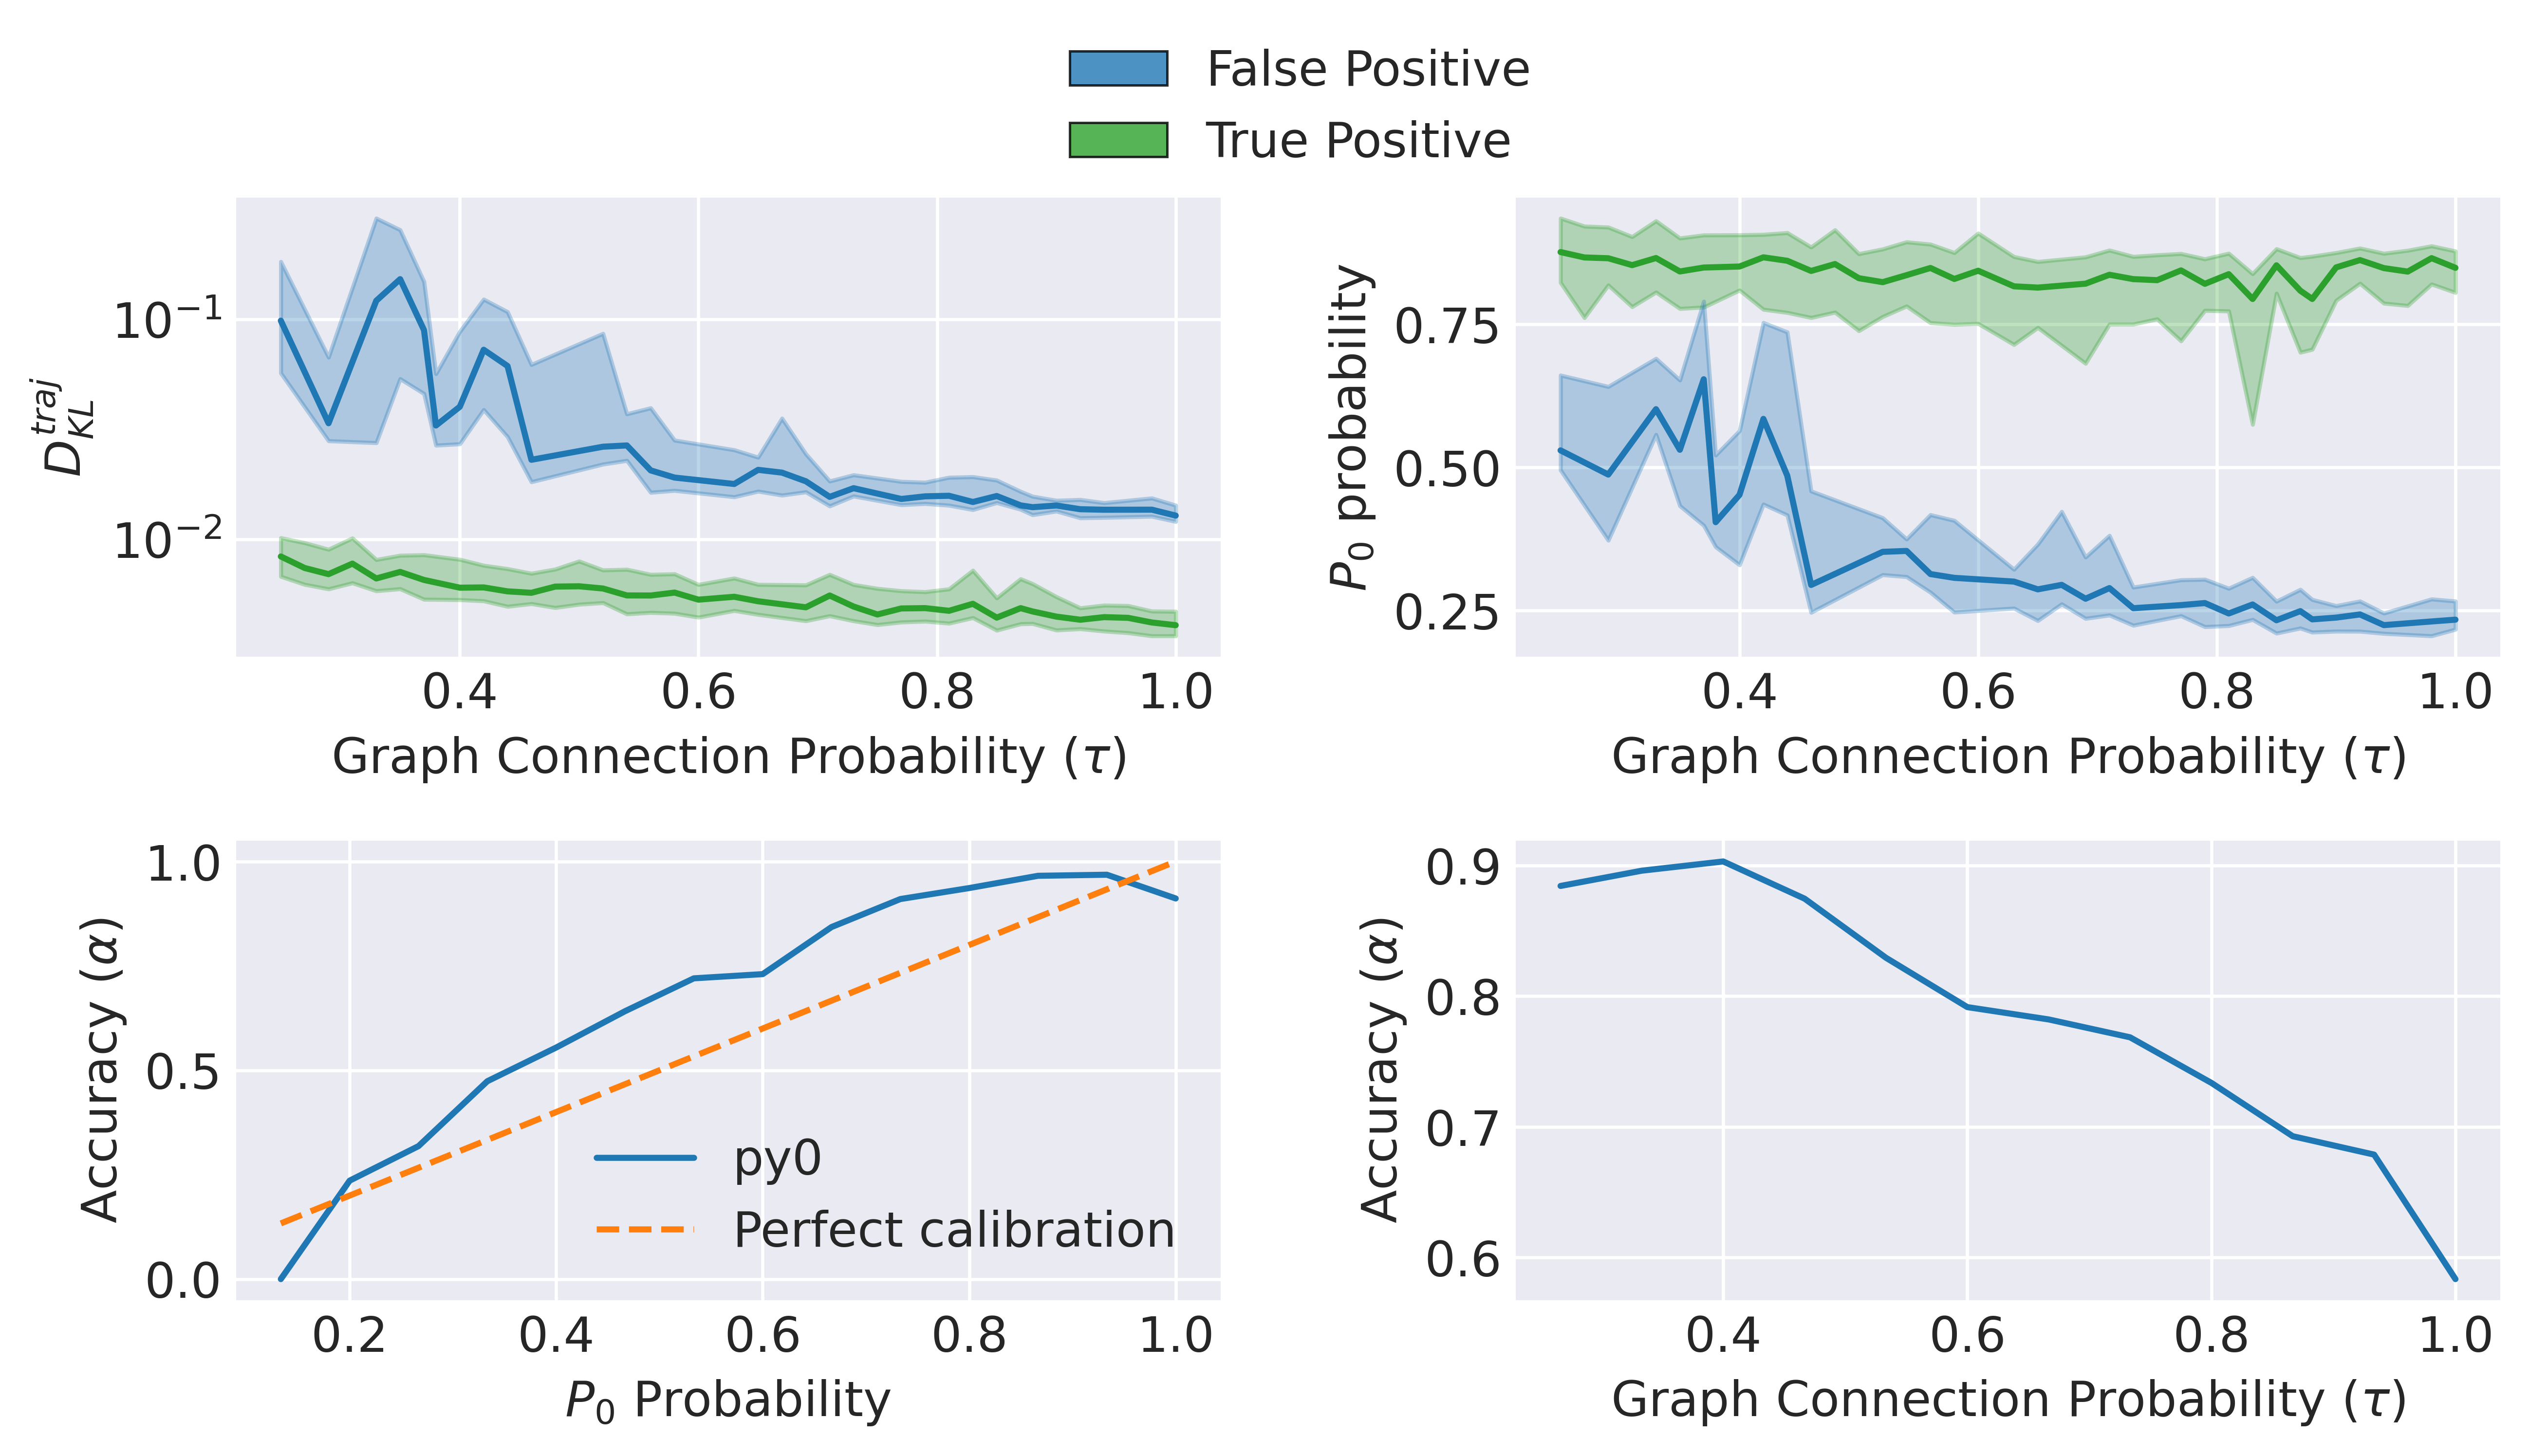

In [7]:
# revised figure with quantiles
connecting_probabilities, traj_losses, p0_losses  = dat[:, 0], dat[:, 1], dat[:, 2]
certainties, predictions, true_nodes, predicted_nodes, model_fit_losses  = dat[:, 3], dat[:, 4].astype(bool), dat[:, 5], dat[:, 6], dat[:, 7]
marker_colors = []
alpha = 0.8
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probabilities)):
    if predictions[i]:
        marker_colors.append('C2')
    else:
        marker_colors.append('C0')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), dpi=600)
ax[0,0].set_xlabel('Graph Connection Probability ($\\tau$)')
# ax[0,0].set_ylabel('Traj K-L Divergence loss') $D_{\textrm{KL}} ^{\textrm{traj}}$
ax[0,0].set_ylabel('$D_{KL} ^{traj}$') 
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[0,1].set_ylabel('$P_0$ probability')
fps = []
tps = []
fps_p_node = []
tps_p_node = []

min_q = 0.35
max_q = 0.65
p_values = np.round(np.linspace(0.25, 1, 40), 2)
box_traj_loss_T = []
box_traj_loss_F = []
box_certainty_T = []
box_certainty_F = []
for j, p in enumerate(p_values):
    quant_traj_loss_T = []
    quant_traj_loss_F = []
    quant_certainty_T = []
    quant_certainty_F = []
    for i, d in enumerate(dat):
        if d[0] == p:
            if d[4]:
                quant_traj_loss_T.append(traj_losses[i])
                quant_certainty_T.append(certainties[i])
            else:
                quant_traj_loss_F.append(traj_losses[i])
                quant_certainty_F.append(certainties[i])
    box_traj_loss_T.append(np.quantile(np.array(quant_traj_loss_T),[min_q,0.5,max_q]))
    box_traj_loss_F.append(np.quantile(np.array(quant_traj_loss_F),[min_q,0.5,max_q]))
    box_certainty_T.append(np.quantile(np.array(quant_certainty_T),[min_q,0.5,max_q]))
    box_certainty_F.append(np.quantile(np.array(quant_certainty_F),[min_q,0.5,max_q]))
box_traj_loss_T = np.array(box_traj_loss_T)
box_traj_loss_F = np.array(box_traj_loss_F)
box_certainty_T = np.array(box_certainty_T)
box_certainty_F = np.array(box_certainty_F)
# box_traj_loss_T= box_traj_loss_T[~np.isnan(box_traj_loss_T)]
lower_q_T = box_traj_loss_T[:,0]
p_values_T = np.delete(p_values,np.where(np.isnan(box_traj_loss_T[:,2]))[0])
mid_q_T = np.delete(box_traj_loss_T[:,1],np.where(np.isnan(box_traj_loss_T[:,1]))[0])
lower_q_T = np.delete(lower_q_T,np.where(np.isnan(lower_q_T))[0])
upper_q_T = box_traj_loss_T[:,2]
upper_q_T = np.delete(upper_q_T,np.where(np.isnan(upper_q_T))[0])
lower_q_F = box_traj_loss_F[:,0]
p_values_F = np.delete(p_values,np.where(np.isnan(box_traj_loss_F[:,2]))[0])
mid_q_F = np.delete(box_traj_loss_F[:,1],np.where(np.isnan(box_traj_loss_F[:,1]))[0])
lower_q_F = np.delete(lower_q_F,np.where(np.isnan(lower_q_F))[0])
upper_q_F = box_traj_loss_F[:,2]
upper_q_F = np.delete(upper_q_F,np.where(np.isnan(upper_q_F))[0])
# ax[0,0].errorbar(p_values+0.01, box_traj_loss_T[:,1], yerr=(box_traj_loss_T[:,1] - box_traj_loss_T[:,0], box_traj_loss_T[:,2] - box_traj_loss_T[:,1]),
#                  fmt='o', color='C2', alpha=alpha, elinewidth=0.5, capsize=2, markersize=4,markeredgecolor='None')
ax[0,0].plot(p_values_T, mid_q_T, color=f'C2', markersize=4, markeredgecolor='None' )
ax[0,0].fill_between(p_values_T, lower_q_T,
                     upper_q_T,
                    color=f'C2', alpha=alpha-0.5)
ax[0,0].plot(p_values_F, mid_q_F, color=f'C0', markersize=4, markeredgecolor='None' )
ax[0,0].fill_between(p_values_F, lower_q_F,
                     upper_q_F,
                    color=f'C0', alpha=alpha-0.5)
# ax[0,0].errorbar(p_values, box_traj_loss_F[:,1], yerr=(box_traj_loss_F[:,1] - box_traj_loss_F[:,0], box_traj_loss_F[:,2] - box_traj_loss_F[:,1]),
#                  fmt='o', color='C0', alpha=alpha,
#            elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')

lower_q_certainty_T = box_certainty_T[:,0]
p_values_certainty_T = np.delete(p_values,np.where(np.isnan(box_certainty_T[:,2]))[0])
mid_q_certainty_T = np.delete(box_certainty_T[:,1],np.where(np.isnan(box_certainty_T[:,1]))[0])
lower_q_certainty_T = np.delete(lower_q_certainty_T,np.where(np.isnan(lower_q_certainty_T))[0])
upper_q_certainty_T = box_certainty_T[:,2]
upper_q_certainty_T = np.delete(upper_q_certainty_T,np.where(np.isnan(upper_q_certainty_T))[0])
lower_q_certainty_F = box_certainty_F[:,0]
p_values_certainty_F = np.delete(p_values,np.where(np.isnan(box_certainty_F[:,2]))[0])
mid_q_certainty_F = np.delete(box_certainty_F[:,1],np.where(np.isnan(box_certainty_F[:,1]))[0])
lower_q_certainty_F = np.delete(lower_q_certainty_F,np.where(np.isnan(lower_q_certainty_F))[0])
upper_q_certainty_F = box_certainty_F[:,2]
upper_q_certainty_F = np.delete(upper_q_certainty_F,np.where(np.isnan(upper_q_certainty_F))[0])
ax[0,1].plot(p_values_certainty_T, mid_q_certainty_T, color='C2', markersize=4, markeredgecolor='None' )
ax[0,1].fill_between(p_values_certainty_T, lower_q_certainty_T,
                     upper_q_certainty_T,
                    color='C2', alpha=alpha-0.5)
ax[0,1].plot(p_values_certainty_F, mid_q_certainty_F, color='C0', markersize=4, markeredgecolor='None' )
ax[0,1].fill_between(p_values_certainty_F, lower_q_certainty_F,
                     upper_q_certainty_F,
                    color='C0', alpha=alpha-0.5)
# ax[0,1].errorbar(p_values+0.01, box_certainty_T[:,1], yerr=(box_certainty_T[:,1]-box_certainty_T[:,0], box_certainty_T[:,2]-box_certainty_T[:,1]), fmt='o', color='C2', alpha=alpha,
#            elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')
# ax[0,1].errorbar(p_values, box_certainty_F[:,1], yerr=(box_certainty_F[:,1]-box_certainty_F[:,0], box_certainty_F[:,2]-box_certainty_F[:,1]), fmt='o', color='C0', alpha=alpha,
#            elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')

for i, mc in enumerate(marker_colors):
#     ax[0,0].plot(connecting_probabilities[i], traj_losses[i], marker='.', markerfacecolor=mc,
#                markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
#     ax[0,1].plot(connecting_probabilities[i], certainties[i], marker='.', markerfacecolor=mc,
#                markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
        tps_p_node.append(connecting_probabilities[i])
    else:
        fps.append(certainties[i])
        fps_p_node.append(connecting_probabilities[i])
bins = np.linspace(0,1,16)
counts_t, bins_t, bars_t = ax[1,0].hist(tps, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,0].hist(fps, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.4, wspace=0.3)


bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[1,0].clear()
ax[1,0].plot(bins_t, accuracy, label='py0')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[1,0].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
ax[1,0].set_xlabel('$P_0$ Probability')
ax[1,0].set_ylabel(r'Accuracy ($\alpha$)')
legend = ax[1,0].legend()
bins_p_node = np.unique(connecting_probabilities)
counts_f_p_node, bins_f_p_node, bars_f_p_node = ax[1,1].hist(fps_p_node, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
counts_t_p_node, bins_t_p_node, bars_t_p_node = ax[1,1].hist(tps_p_node, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.36, 1.42))
ax[1,1].clear()
accuracy_p_node = counts_t_p_node/(counts_f_p_node + counts_t_p_node)
non_nan_p_node = np.min(np.where(np.isfinite(accuracy_p_node)))
ax[1,1].plot(bins_t,accuracy_p_node, label='Maxent')
ax[1,1].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[1,1].set_ylabel(r'Accuracy ($\alpha$)')
plt.rcParams['font.size'] = '12'
# plt.tight_layout()
# plt.savefig('adjust_p_grah_quatiles.svg', dpi=600, bbox_inches='tight' )

[0.00837612 0.0074243  0.00696253 0.00777233 0.00665558 0.0071259
 0.00655221 0.00604278 0.00606021 0.00581546 0.00572873 0.00611267
 0.00613195 0.00599101 0.00557331 0.00556851 0.00574066 0.00533166
 0.00549515 0.00524291 0.00492201 0.00556783 0.00496135 0.0045661
 0.00486341 0.00488008 0.00474513 0.00510588 0.00441897 0.00487838
 0.00471301 0.00446488 0.00432183 0.00444045 0.00440871 0.00419862
 0.00408203]


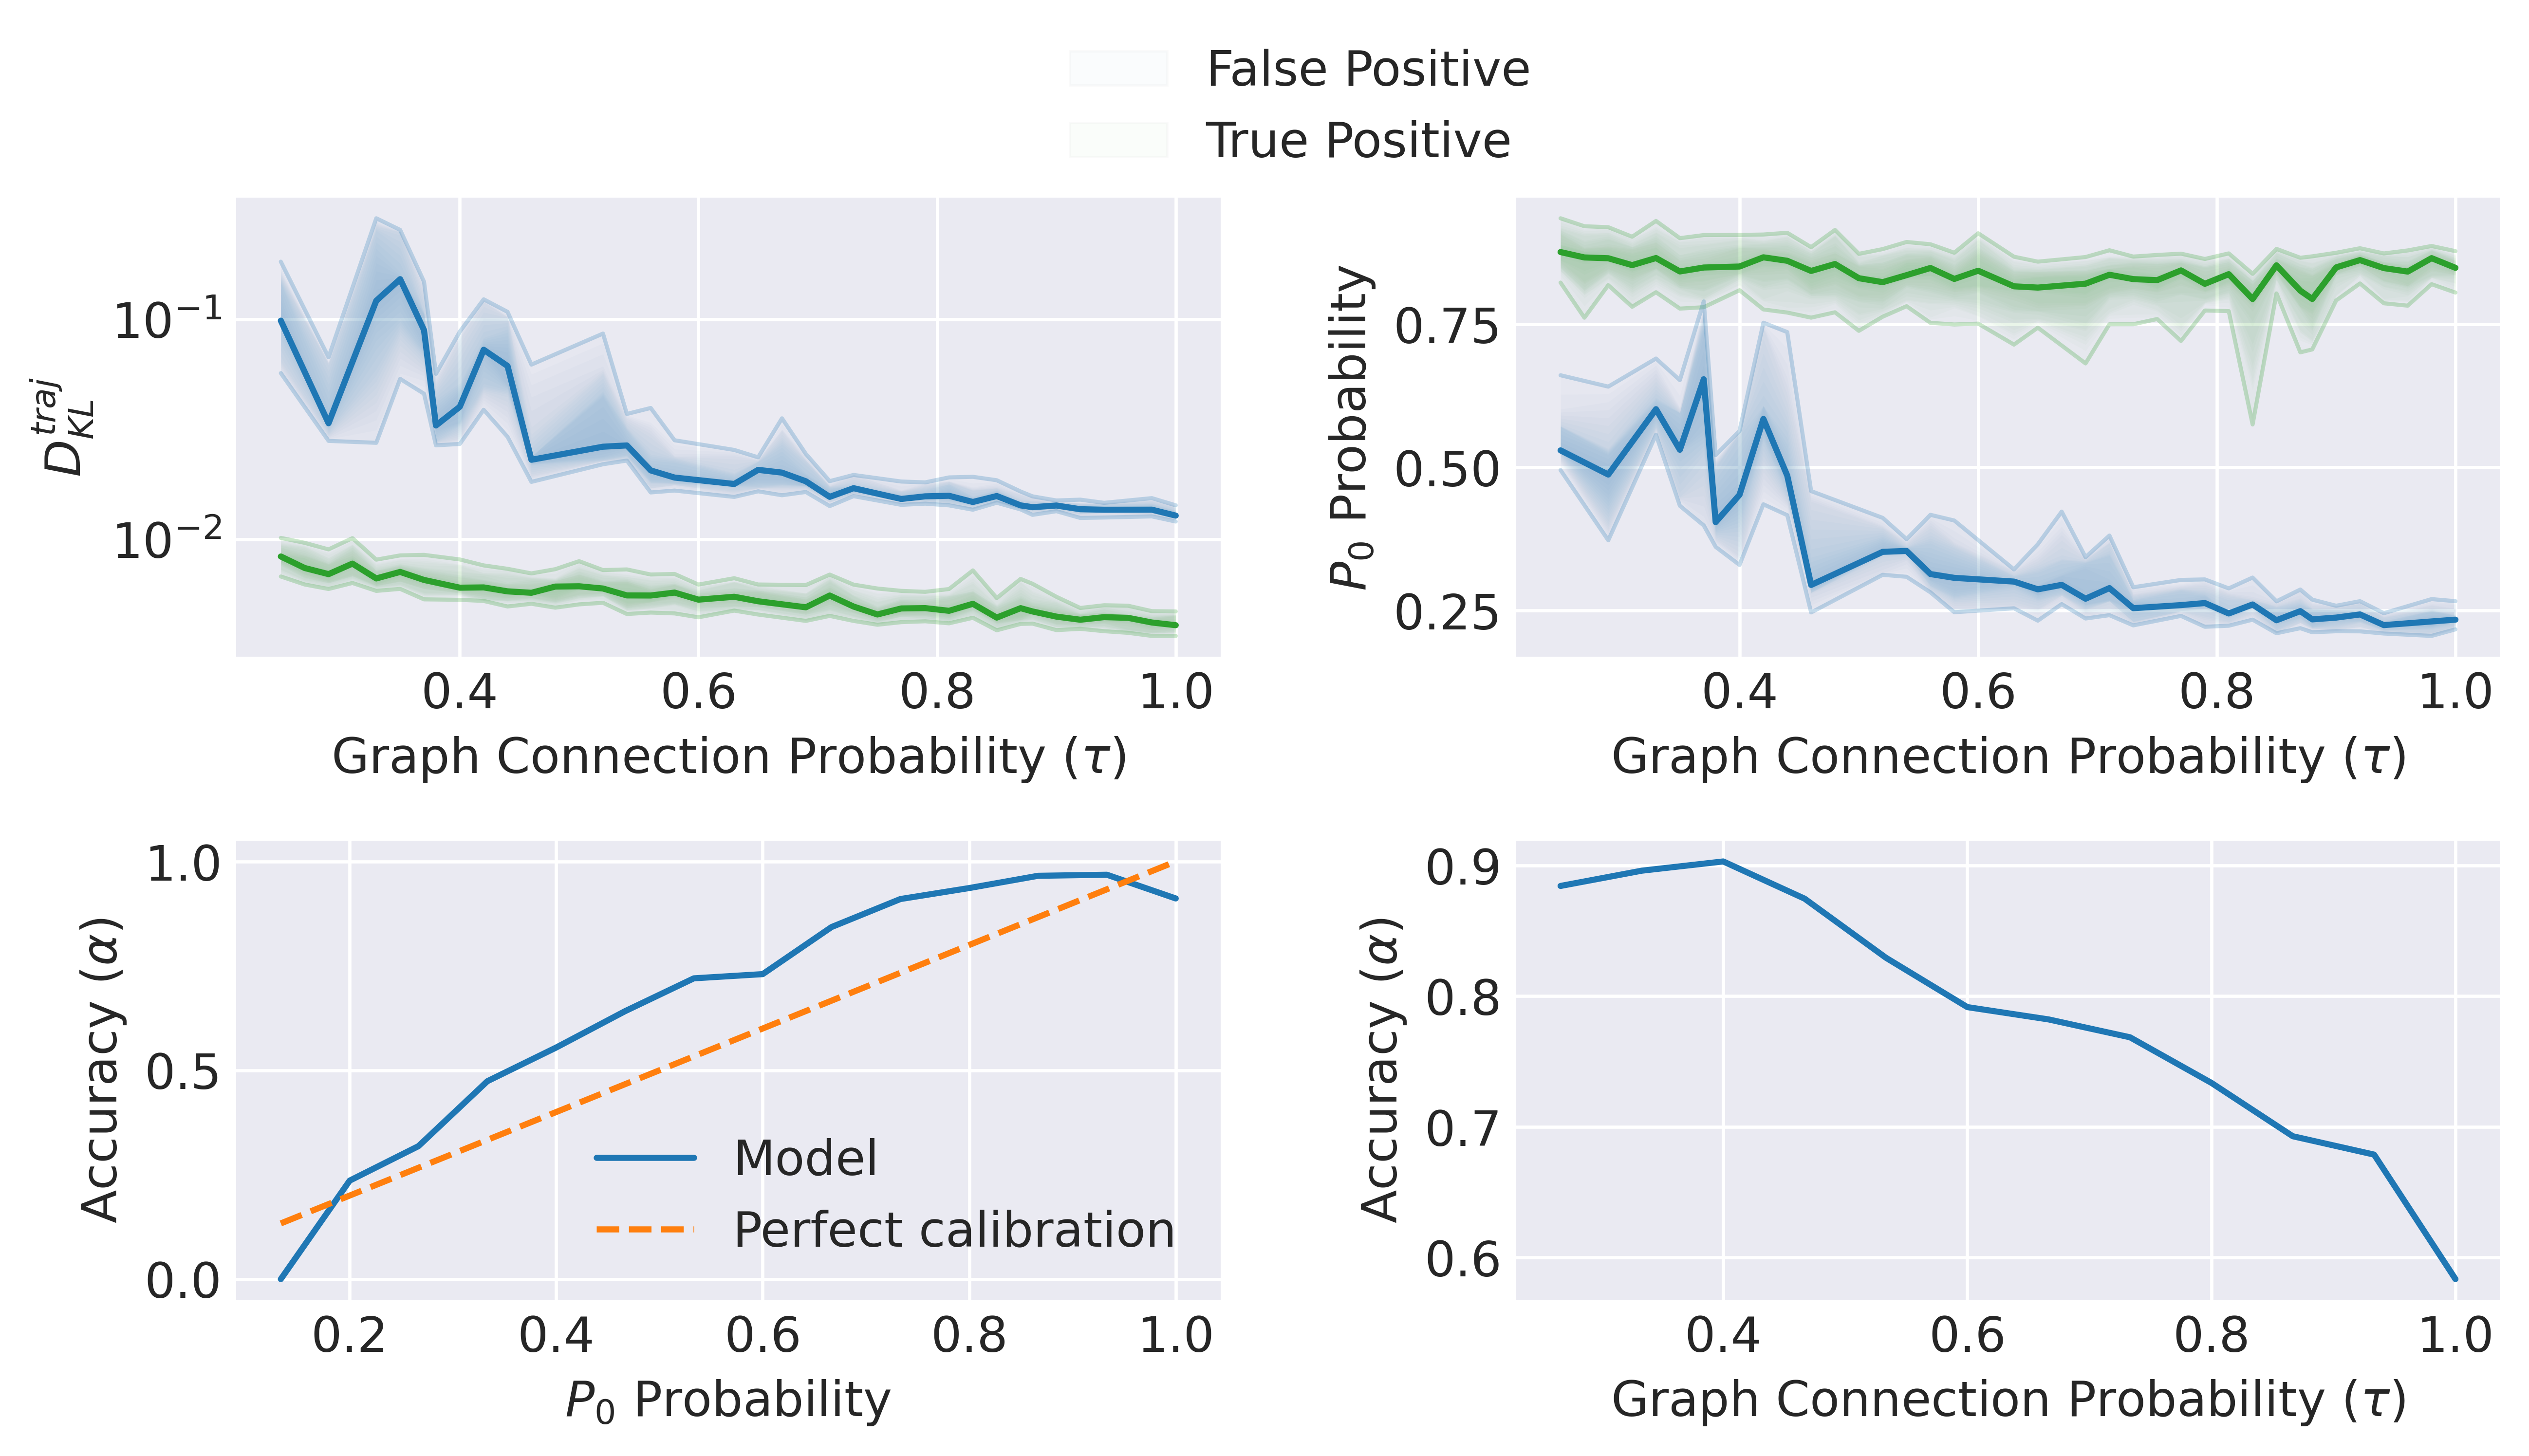

In [8]:
# revised figure with quantiles with fancy gradeint shadings
connecting_probabilities, traj_losses, p0_losses  = dat[:, 0], dat[:, 1], dat[:, 2]
certainties, predictions, true_nodes, predicted_nodes, model_fit_losses  = dat[:, 3], dat[:, 4].astype(bool), dat[:, 5], dat[:, 6], dat[:, 7]
marker_colors = []

# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probabilities)):
    if predictions[i]:
        marker_colors.append('C2')
    else:
        marker_colors.append('C0')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), dpi=600)
ax[0,0].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[0,0].set_ylabel('$D_{KL} ^{traj}$')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[0,1].set_ylabel('$P_0$ Probability')
fps = []
tps = []
fps_p_node = []
tps_p_node = []

min_q = 0.35
max_q = 0.65
p_values = np.round(np.linspace(0.25, 1, 40), 2)
shading_gradients = 20
fancy_lower_q_bounds = np.linspace(min_q, 0.5, shading_gradients)
fancy_higher_q_bounds = 1 - fancy_lower_q_bounds
alpha = 0.02
alpha = np.linspace(0.01, alpha, shading_gradients)
alpha_edge = 0.25
linewidth_edge = 1
all_lower_q_T = []
all_lower_q_F = []
all_upper_q_T = []
all_upper_q_F = []
all_upper_q_certainty_T = []
all_lower_q_certainty_T = []
all_upper_q_certainty_F = []
all_lower_q_certainty_F = []
for n in range(shading_gradients):
    min_q = fancy_lower_q_bounds[n]
    max_q = fancy_higher_q_bounds[n]
    adjusted_alpha = alpha[n]
    adjusted_alpha = 0.02
    box_traj_loss_T = []
    box_traj_loss_F = []
    box_certainty_T = []
    box_certainty_F = []
    for j, p in enumerate(p_values):
        quant_traj_loss_T = []
        quant_traj_loss_F = []
        quant_certainty_T = []
        quant_certainty_F = []
        for i, d in enumerate(dat):
            if d[0] == p:
                if d[4]:
                    quant_traj_loss_T.append(traj_losses[i])
                    quant_certainty_T.append(certainties[i])
                else:
                    quant_traj_loss_F.append(traj_losses[i])
                    quant_certainty_F.append(certainties[i])
        box_traj_loss_T.append(np.quantile(np.array(quant_traj_loss_T),[min_q,0.5,max_q]))
        box_traj_loss_F.append(np.quantile(np.array(quant_traj_loss_F),[min_q,0.5,max_q]))
        box_certainty_T.append(np.quantile(np.array(quant_certainty_T),[min_q,0.5,max_q]))
        box_certainty_F.append(np.quantile(np.array(quant_certainty_F),[min_q,0.5,max_q]))
    box_traj_loss_T = np.array(box_traj_loss_T)
    box_traj_loss_F = np.array(box_traj_loss_F)
    box_certainty_T = np.array(box_certainty_T)
    box_certainty_F = np.array(box_certainty_F)
    # box_traj_loss_T= box_traj_loss_T[~np.isnan(box_traj_loss_T)]
    lower_q_T = box_traj_loss_T[:,0]
    p_values_T = np.delete(p_values,np.where(np.isnan(box_traj_loss_T[:,2]))[0])
    mid_q_T = np.delete(box_traj_loss_T[:,1],np.where(np.isnan(box_traj_loss_T[:,1]))[0])
    lower_q_T = np.delete(lower_q_T,np.where(np.isnan(lower_q_T))[0])
    upper_q_T = box_traj_loss_T[:,2]
    upper_q_T = np.delete(upper_q_T,np.where(np.isnan(upper_q_T))[0])
    lower_q_F = box_traj_loss_F[:,0]
    p_values_F = np.delete(p_values,np.where(np.isnan(box_traj_loss_F[:,2]))[0])
    mid_q_F = np.delete(box_traj_loss_F[:,1],np.where(np.isnan(box_traj_loss_F[:,1]))[0])
    lower_q_F = np.delete(lower_q_F,np.where(np.isnan(lower_q_F))[0])
    upper_q_F = box_traj_loss_F[:,2]
    upper_q_F = np.delete(upper_q_F,np.where(np.isnan(upper_q_F))[0])
    all_lower_q_T.append(lower_q_T)
    all_lower_q_F.append(lower_q_F)
    all_upper_q_T.append(upper_q_T)
    all_upper_q_F.append(upper_q_F)
    # ax[0,0].errorbar(p_values+0.01, box_traj_loss_T[:,1], yerr=(box_traj_loss_T[:,1] - box_traj_loss_T[:,0], box_traj_loss_T[:,2] - box_traj_loss_T[:,1]),
    #                  fmt='o', color='C2', alpha=alpha, elinewidth=0.5, capsize=2, markersize=4,markeredgecolor='None')
#     print('traj loss qs:',lower_q_F[9], upper_q_F[9],p_values_T[9])
    ax[0,0].fill_between(p_values_T, lower_q_T,
                         upper_q_T,
                        color=f'C2', alpha=adjusted_alpha, linewidth=0.0)
    ax[0,0].fill_between(p_values_F, lower_q_F,
                         upper_q_F,
                        color=f'C0', alpha=adjusted_alpha, linewidth=0.0)
    # ax[0,0].errorbar(p_values, box_traj_loss_F[:,1], yerr=(box_traj_loss_F[:,1] - box_traj_loss_F[:,0], box_traj_loss_F[:,2] - box_traj_loss_F[:,1]),
    #                  fmt='o', color='C0', alpha=alpha,
    #            elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')

    lower_q_certainty_T = box_certainty_T[:,0]
    p_values_certainty_T = np.delete(p_values,np.where(np.isnan(box_certainty_T[:,2]))[0])
    mid_q_certainty_T = np.delete(box_certainty_T[:,1],np.where(np.isnan(box_certainty_T[:,1]))[0])
    lower_q_certainty_T = np.delete(lower_q_certainty_T,np.where(np.isnan(lower_q_certainty_T))[0])
    upper_q_certainty_T = box_certainty_T[:,2]
    upper_q_certainty_T = np.delete(upper_q_certainty_T,np.where(np.isnan(upper_q_certainty_T))[0])
    lower_q_certainty_F = box_certainty_F[:,0]
    p_values_certainty_F = np.delete(p_values,np.where(np.isnan(box_certainty_F[:,2]))[0])
    mid_q_certainty_F = np.delete(box_certainty_F[:,1],np.where(np.isnan(box_certainty_F[:,1]))[0])
    lower_q_certainty_F = np.delete(lower_q_certainty_F,np.where(np.isnan(lower_q_certainty_F))[0])
    upper_q_certainty_F = box_certainty_F[:,2]
    upper_q_certainty_F = np.delete(upper_q_certainty_F,np.where(np.isnan(upper_q_certainty_F))[0])
    ax[0,1].fill_between(p_values_certainty_T, lower_q_certainty_T,
                         upper_q_certainty_T,
                        color='C2', alpha=adjusted_alpha, linewidth=0.0)
    ax[0,1].fill_between(p_values_certainty_F, lower_q_certainty_F,
                         upper_q_certainty_F,
                        color='C0', alpha=adjusted_alpha, linewidth=0.0)
    all_upper_q_certainty_T.append(upper_q_certainty_T)
    all_lower_q_certainty_T.append(lower_q_certainty_T)
    all_upper_q_certainty_F.append(upper_q_certainty_F)
    all_lower_q_certainty_F.append(lower_q_certainty_F)
    if n == 0:
        ax[0,0].plot(p_values_F, mid_q_F, color=f'C0', markersize=4, markeredgecolor='None')
        ax[0,0].plot(p_values_T, mid_q_T, color=f'C2', markersize=4, markeredgecolor='None')
        ax[0,0].plot(p_values_T, lower_q_T,
                    color=f'C2', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,0].plot(p_values_T, upper_q_T,
            color=f'C2', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,0].plot(p_values_F, upper_q_F,
            color=f'C0', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,0].plot(p_values_F, lower_q_F,
                    color=f'C0', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,1].plot(p_values_certainty_T, mid_q_certainty_T, color='C2', markersize=4, markeredgecolor='None')
        ax[0,1].plot(p_values_certainty_F, mid_q_certainty_F, color='C0', markersize=4, markeredgecolor='None')
        ax[0,1].plot(p_values_certainty_T, lower_q_certainty_T,
                        color='C2', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,1].plot(p_values_certainty_T, upper_q_certainty_T,
                color='C2', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,1].plot(p_values_certainty_F, lower_q_certainty_F,
                        color='C0', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,1].plot(p_values_certainty_F, upper_q_certainty_F,
                color='C0', alpha=alpha_edge, linewidth=linewidth_edge)

# ax[0,1].errorbar(p_values+0.01, box_certainty_T[:,1], yerr=(box_certainty_T[:,1]-box_certainty_T[:,0], box_certainty_T[:,2]-box_certainty_T[:,1]), fmt='o', color='C2', alpha=alpha,
#            elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')
# ax[0,1].errorbar(p_values, box_certainty_F[:,1], yerr=(box_certainty_F[:,1]-box_certainty_F[:,0], box_certainty_F[:,2]-box_certainty_F[:,1]), fmt='o', color='C0', alpha=alpha,
#            elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')
alpha=alpha[-1]
for i, mc in enumerate(marker_colors):
#     ax[0,0].plot(connecting_probabilities[i], traj_losses[i], marker='.', markerfacecolor=mc,
#                markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
#     ax[0,1].plot(connecting_probabilities[i], certainties[i], marker='.', markerfacecolor=mc,
#                markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
        tps_p_node.append(connecting_probabilities[i])
    else:
        fps.append(certainties[i])
        fps_p_node.append(connecting_probabilities[i])
bins = np.linspace(0,1,16)
counts_t, bins_t, bars_t = ax[1,0].hist(tps, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,0].hist(fps, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.4, wspace=0.3)


bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[1,0].clear()
ax[1,0].plot(bins_t, accuracy, label='Model')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[1,0].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
ax[1,0].set_xlabel('$P_0$ Probability')
ax[1,0].set_ylabel(r'Accuracy ($\alpha$)')
legend = ax[1,0].legend()
bins_p_node = np.unique(connecting_probabilities)
counts_f_p_node, bins_f_p_node, bars_f_p_node = ax[1,1].hist(fps_p_node, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
counts_t_p_node, bins_t_p_node, bars_t_p_node = ax[1,1].hist(tps_p_node, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.36, 1.42))
ax[1,1].clear()
accuracy_p_node = counts_t_p_node/(counts_f_p_node + counts_t_p_node)
non_nan_p_node = np.min(np.where(np.isfinite(accuracy_p_node)))
ax[1,1].plot(bins_t,accuracy_p_node, label='Maxent')
ax[1,1].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[1,1].set_ylabel(r'Accuracy ($\alpha$)')
plt.rcParams['font.size'] = '12'
# plt.tight_layout()
# plt.savefig('adjust_p_grah_quatiles_model_tag.svg', dpi=600, bbox_inches='tight' )
print(lower_q_T)

In [20]:
np.mean(abs(bins_t[1:] - accuracy[1:]))

0.1228080813045969

In [21]:
bins_t

array([0.06666667, 0.13333333, 0.2       , 0.26666667, 0.33333333,
       0.4       , 0.46666667, 0.53333333, 0.6       , 0.66666667,
       0.73333333, 0.8       , 0.86666667, 0.93333333, 1.        ])

In [17]:
accuracy

array([       nan, 0.        , 0.2357513 , 0.31841432, 0.47379455,
       0.55445545, 0.64143426, 0.72016461, 0.73021583, 0.84294872,
       0.91      , 0.93630573, 0.96566524, 0.96821192, 0.91138211])

In [57]:

adjusted_alpha = adjusted_alpha/np.sum(adjusted_alpha)
adjusted_alpha

1.0

In [58]:
np.sum(all_upper_q_T, axis=1)

array([0.25556569, 0.25167343, 0.24868567, 0.24477064, 0.24178111,
       0.2387918 , 0.23560838, 0.2325752 , 0.22956738, 0.22703609,
       0.22484958, 0.22300067, 0.22064205, 0.21844333, 0.21612051,
       0.21340506, 0.21092117, 0.20919795, 0.20735105, 0.20524265])

In [59]:
np.repeat(p_values_T[np.newaxis,:], 25, axis=0).shape

(25, 37)

In [60]:
adjusted_alpha = (all_lower_q_T/ np.sum(all_lower_q_T,axis=0, keepdims=True))
adjusted_alpha[0]

array([0.04478943, 0.04618334, 0.04667288, 0.04534196, 0.04737729,
       0.04605452, 0.0451074 , 0.04653314, 0.0474909 , 0.04618876,
       0.04689071, 0.04616067, 0.04518446, 0.0457589 , 0.04595288,
       0.04590017, 0.04413189, 0.04506817, 0.0469755 , 0.04615503,
       0.04650157, 0.04532095, 0.04614366, 0.04757738, 0.04668019,
       0.04696115, 0.04727424, 0.04635938, 0.04693071, 0.04700626,
       0.04647231, 0.04675276, 0.04781156, 0.04635913, 0.04691363,
       0.04724217, 0.04701289])

In [61]:
adjusted_alpha = np.histogram(all_upper_q_T[:,n], density=True, bins=all_lower_q_T.shape[1]-1)[1]
adjusted_alpha = adjusted_alpha/np.sum(adjusted_alpha)
adjusted_alpha

array([0.02466186, 0.02479325, 0.02492465, 0.02505605, 0.02518745,
       0.02531885, 0.02545025, 0.02558165, 0.02571304, 0.02584444,
       0.02597584, 0.02610724, 0.02623864, 0.02637004, 0.02650143,
       0.02663283, 0.02676423, 0.02689563, 0.02702703, 0.02715843,
       0.02728982, 0.02742122, 0.02755262, 0.02768402, 0.02781542,
       0.02794682, 0.02807821, 0.02820961, 0.02834101, 0.02847241,
       0.02860381, 0.02873521, 0.0288666 , 0.028998  , 0.0291294 ,
       0.0292608 , 0.0293922 ])

In [62]:
np.histogram(all_upper_q_T[:,n], density=True, bins=all_lower_q_T.shape[1]-1)[1]

array([0.00524291, 0.00527084, 0.00529878, 0.00532671, 0.00535464,
       0.00538258, 0.00541051, 0.00543845, 0.00546638, 0.00549431,
       0.00552225, 0.00555018, 0.00557812, 0.00560605, 0.00563399,
       0.00566192, 0.00568985, 0.00571779, 0.00574572, 0.00577366,
       0.00580159, 0.00582953, 0.00585746, 0.00588539, 0.00591333,
       0.00594126, 0.0059692 , 0.00599713, 0.00602506, 0.006053  ,
       0.00608093, 0.00610887, 0.0061368 , 0.00616474, 0.00619267,
       0.0062206 , 0.00624854])

[0.0451563  0.04566616 0.04617603 0.04668589 0.04719575 0.04770562
 0.04821548 0.04872534 0.04923521 0.04974507 0.05025493 0.05076479
 0.05127466 0.05178452 0.05229438 0.05280425 0.05331411 0.05382397
 0.05433384 0.0548437 ]
[0.04345899 0.04414752 0.04483605 0.04552458 0.0462131  0.04690163
 0.04759016 0.04827868 0.04896721 0.04965574 0.05034426 0.05103279
 0.05172132 0.05240984 0.05309837 0.0537869  0.05447542 0.05516395
 0.05585248 0.05654101]
[0.0435683  0.04424532 0.04492234 0.04559936 0.04627638 0.04695341
 0.04763043 0.04830745 0.04898447 0.04966149 0.05033851 0.05101553
 0.05169255 0.05236957 0.05304659 0.05372362 0.05440064 0.05507766
 0.05575468 0.0564317 ]
[0.04337681 0.04407398 0.04477116 0.04546834 0.04616552 0.0468627
 0.04755988 0.04825705 0.04895423 0.04965141 0.05034859 0.05104577
 0.05174295 0.05244012 0.0531373  0.05383448 0.05453166 0.05522884
 0.05592602 0.05662319]
[0.04510105 0.04561673 0.04613241 0.04664809 0.04716377 0.04767945
 0.04819512 0.0487108  0.04922648 

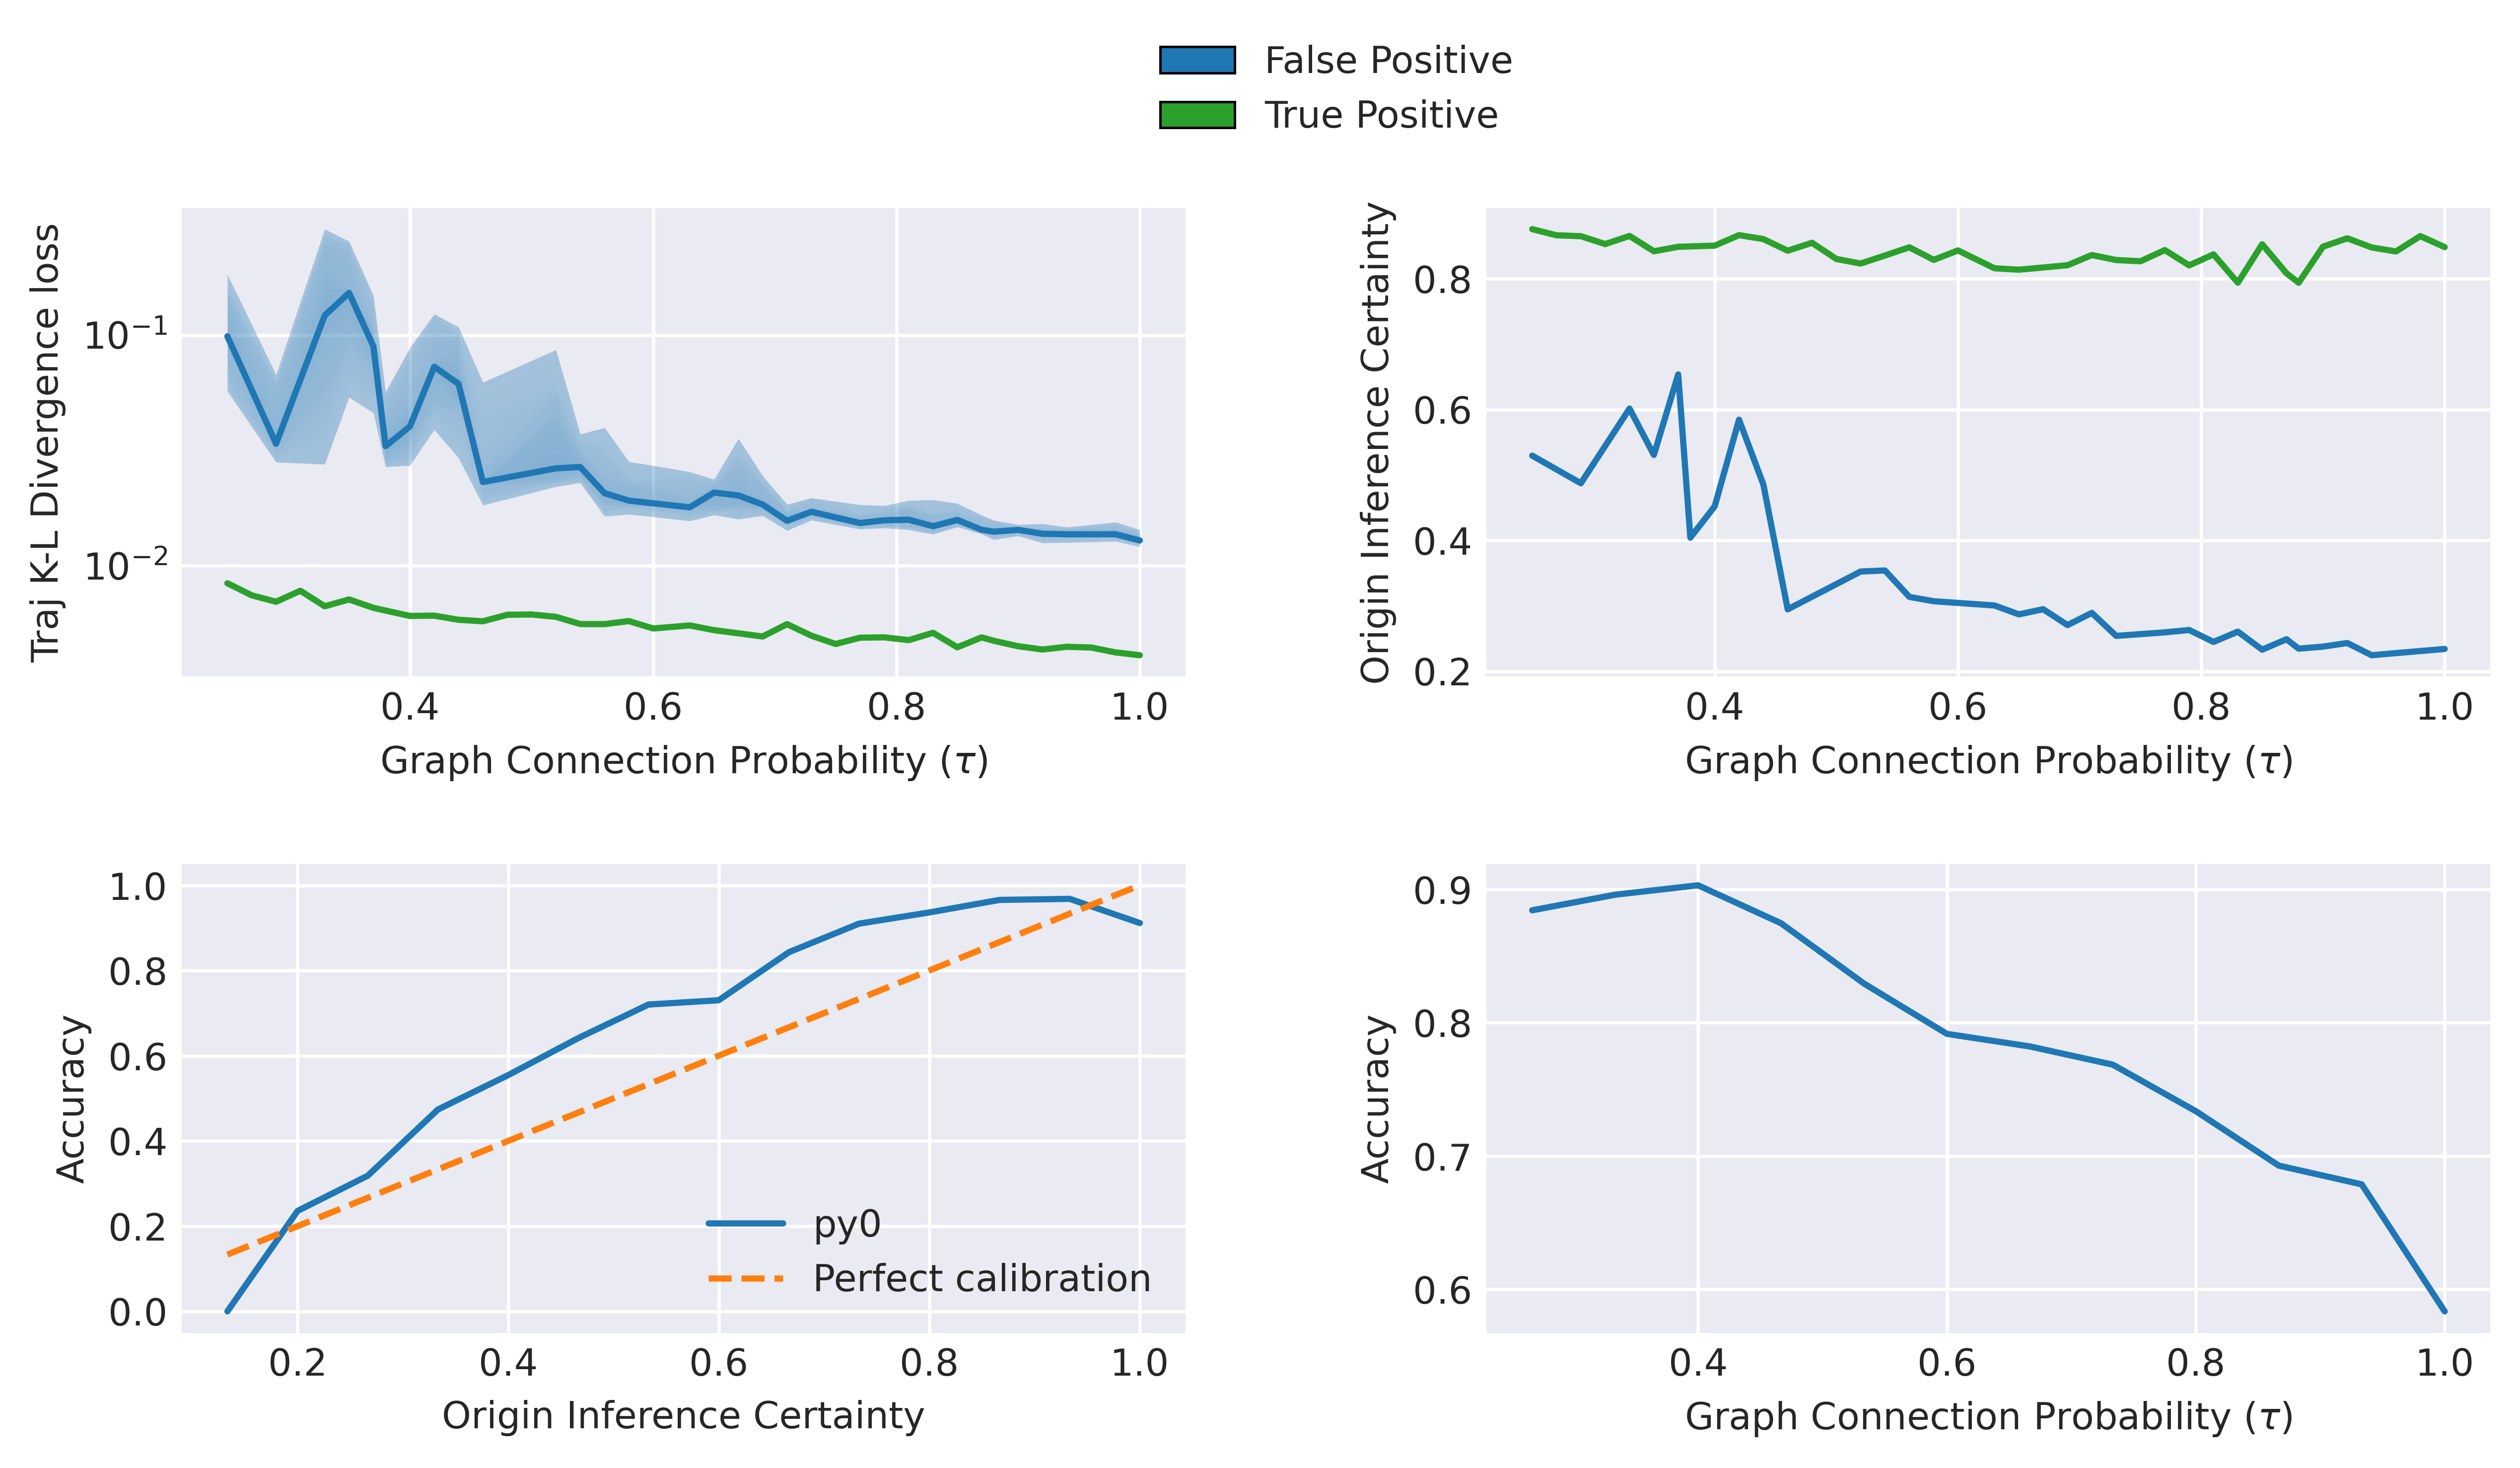

In [65]:
# revised figure with quantiles with fancy gradeint shadings
connecting_probabilities, traj_losses, p0_losses  = dat[:, 0], dat[:, 1], dat[:, 2]
certainties, predictions, true_nodes, predicted_nodes, model_fit_losses  = dat[:, 3], dat[:, 4].astype(bool), dat[:, 5], dat[:, 6], dat[:, 7]
marker_colors = []

# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probabilities)):
    if predictions[i]:
        marker_colors.append('C2')
    else:
        marker_colors.append('C0')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), dpi=600)
ax[0,0].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[0,1].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
fps_p_node = []
tps_p_node = []

min_q = 0.35
max_q = 0.65
p_values = np.round(np.linspace(0.25, 1, 40), 2)
shading_gradients = 20
fancy_lower_q_bounds = np.linspace(min_q, 0.5, shading_gradients)
fancy_higher_q_bounds = 1 - fancy_lower_q_bounds
alpha = 1
alpha = np.linspace(0.01, alpha, shading_gradients)
alpha_edge = 0.25
linewidth_edge = 1
for n in range(shading_gradients-1):
    adjusted_alpha = alpha[n]
#     adjusted_alpha = 1
#     for m in range(all_lower_q_F.shape[1]):
#         print(all_lower_q_T[n, m],all_lower_q_T[n+1, m])
#         adjusted_alpha = (all_lower_q_F/ np.sum(all_lower_q_F,axis=0, keepdims=True))
    adjusted_alpha = np.histogram(all_upper_q_T[:,n], density=True, bins=shading_gradients-1)[1]
    adjusted_alpha = adjusted_alpha/np.sum(adjusted_alpha)
        
#         print(adjusted_alpha[n,m])
#     ax[0,0].fill_between(p_values_T, all_lower_q_T[n, :],
#                          all_lower_q_T[n+1, :],
#                         color=f'C2', alpha=alpha[n], linewidth=0.0)
    print(adjusted_alpha)
    ax[0,0].fill_between(p_values_F, all_lower_q_F[n, :],
                          all_lower_q_F[n+1, :],
                        color=f'C0', alpha=fancy_lower_q_bounds[n], linewidth=0.0)
    ax[0,0].fill_between(p_values_F, all_upper_q_F[n, :],
                      all_upper_q_F[n+1, :],
                    color=f'C0', alpha=1-fancy_higher_q_bounds[n], linewidth=0.0)
#     ax[0,1].fill_between(p_values_certainty_T, lower_q_certainty_T,
#                          upper_q_certainty_T,
#                         color='C2', alpha=adjusted_alpha[n,m], linewidth=0.0)
#     ax[0,1].fill_between(p_values_certainty_F, lower_q_certainty_F,
#                          upper_q_certainty_F,
#                         color='C0', alpha=adjusted_alpha[n,m], linewidth=0.0)
    
    if n == 0:
        ax[0,0].plot(p_values_F, mid_q_F, color=f'C0', markersize=4, markeredgecolor='None')
        ax[0,0].plot(p_values_T, mid_q_T, color=f'C2', markersize=4, markeredgecolor='None')
        ax[0,0].plot(p_values_T, lower_q_T,
                    color=f'C2', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,0].plot(p_values_T, upper_q_T,
            color=f'C2', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,0].plot(p_values_F, upper_q_F,
            color=f'C0', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,0].plot(p_values_F, lower_q_F,
                    color=f'C0', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,1].plot(p_values_certainty_T, mid_q_certainty_T, color='C2', markersize=4, markeredgecolor='None')
        ax[0,1].plot(p_values_certainty_F, mid_q_certainty_F, color='C0', markersize=4, markeredgecolor='None')
        ax[0,1].plot(p_values_certainty_T, lower_q_certainty_T,
                        color='C2', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,1].plot(p_values_certainty_T, upper_q_certainty_T,
                color='C2', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,1].plot(p_values_certainty_F, lower_q_certainty_F,
                        color='C0', alpha=alpha_edge, linewidth=linewidth_edge)
        ax[0,1].plot(p_values_certainty_F, upper_q_certainty_F,
                color='C0', alpha=alpha_edge, linewidth=linewidth_edge)


alpha=alpha[-1]
for i, mc in enumerate(marker_colors):
#     ax[0,0].plot(connecting_probabilities[i], traj_losses[i], marker='.', markerfacecolor=mc,
#                markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
#     ax[0,1].plot(connecting_probabilities[i], certainties[i], marker='.', markerfacecolor=mc,
#                markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
        tps_p_node.append(connecting_probabilities[i])
    else:
        fps.append(certainties[i])
        fps_p_node.append(connecting_probabilities[i])
bins = np.linspace(0,1,16)
counts_t, bins_t, bars_t = ax[1,0].hist(tps, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,0].hist(fps, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.4, wspace=0.3)


bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[1,0].clear()
ax[1,0].plot(bins_t, accuracy, label='py0')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[1,0].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
ax[1,0].set_xlabel('Origin Inference Certainty')
ax[1,0].set_ylabel('Accuracy')
legend = ax[1,0].legend()
bins_p_node = np.unique(connecting_probabilities)
counts_f_p_node, bins_f_p_node, bars_f_p_node = ax[1,1].hist(fps_p_node, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
counts_t_p_node, bins_t_p_node, bars_t_p_node = ax[1,1].hist(tps_p_node, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.36, 1.42))
ax[1,1].clear()
accuracy_p_node = counts_t_p_node/(counts_f_p_node + counts_t_p_node)
non_nan_p_node = np.min(np.where(np.isfinite(accuracy_p_node)))
ax[1,1].plot(bins_t,accuracy_p_node, label='Maxent')
ax[1,1].set_xlabel('Graph Connection Probability ($\\tau$)')
ax[1,1].set_ylabel('Accuracy')
plt.rcParams['font.size'] = '9'
# plt.tight_layout()
# plt.savefig('adjust_p_grah_quatiles.svg', dpi=600, bbox_inches='tight' )

In [64]:
fancy_lower_q_bounds

array([0.35      , 0.35789474, 0.36578947, 0.37368421, 0.38157895,
       0.38947368, 0.39736842, 0.40526316, 0.41315789, 0.42105263,
       0.42894737, 0.43684211, 0.44473684, 0.45263158, 0.46052632,
       0.46842105, 0.47631579, 0.48421053, 0.49210526, 0.5       ])

In [120]:
adjusted_alpha.shape

(25, 37)

In [109]:
lower_q_certainty_T

array([0.45789297, 0.41087539, 0.45243454, 0.49561699, 0.52980648,
       0.38105094, 0.4739626 , 0.47653673, 0.55313177, 0.440452  ,
       0.54301879, 0.61588139, 0.58207864, 0.56019411, 0.58319394,
       0.54404127, 0.60469989, 0.61572214, 0.57310853, 0.58272573,
       0.60044798, 0.59435876, 0.59660439, 0.61339632, 0.64846478,
       0.61929204, 0.60576492, 0.60340228, 0.66829371, 0.62627842,
       0.61402994, 0.6608955 , 0.64804326, 0.64777293, 0.65693069,
       0.67315539, 0.66187048])

In [89]:
lower_q_T

array([0.00467193, 0.00378571, 0.00345097, 0.00407228, 0.00348052,
       0.00390992, 0.00340694, 0.00296477, 0.00274785, 0.00278069,
       0.0024385 , 0.00323608, 0.00280577, 0.00273312, 0.00247595,
       0.00259727, 0.002742  , 0.00258634, 0.00250647, 0.00257843,
       0.00182545, 0.00256831, 0.00202727, 0.00159732, 0.00223175,
       0.00177529, 0.00192561, 0.0020428 , 0.0016366 , 0.00202918,
       0.00172189, 0.00173053, 0.00153015, 0.00173805, 0.00166875,
       0.00139557, 0.0015339 ])

In [86]:


p_values_T

array([0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.4 , 0.42, 0.44, 0.46,
       0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.63, 0.65, 0.69, 0.71,
       0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87, 0.88, 0.9 , 0.92,
       0.94, 0.96, 0.98, 1.  ])

In [72]:
box_traj_loss_T[7,1]

nan

In [73]:
box_traj_loss_F

array([[0.02525155, 0.0986746 , 0.85558449],
       [       nan,        nan,        nan],
       [0.01506629, 0.0337397 , 1.05506253],
       [       nan,        nan,        nan],
       [0.01583404, 0.12154263, 0.84079693],
       [0.01783347, 0.15227754, 0.88958061],
       [0.01592756, 0.0893227 , 0.50060196],
       [0.01760412, 0.03295405, 1.81554067],
       [0.02113031, 0.04009629, 0.42067945],
       [0.01430055, 0.0727705 , 0.63507444],
       [0.00674   , 0.06140062, 0.99936271],
       [0.01291603, 0.02302482, 0.47662085],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [0.01327683, 0.02639931, 0.57032533],
       [0.01142545, 0.02675202, 0.44938366],
       [0.01092302, 0.02060421, 0.65646799],
       [0.0064174 , 0.0191149 , 0.25518039],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [0.01167293, 0.01787657, 0.68248301],
       [0.01245805, 0.02072323, 0.22989681],
       [0.

In [53]:
p_values

array([0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.63, 0.65,
       0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [56]:
box_traj_loss_T[:,1] - box_traj_loss_T[:,0]

array([0.00467193, 0.00378571, 0.00345097, 0.00407228, 0.00348052,
       0.00390992, 0.00340694,        nan, 0.00296477, 0.00274785,
       0.00278069, 0.0024385 , 0.00323608, 0.00280577, 0.00273312,
       0.00247595, 0.00259727, 0.002742  , 0.00258634,        nan,
       0.00250647, 0.00257843,        nan, 0.00182545, 0.00256831,
       0.00202727, 0.00159732, 0.00223175, 0.00177529, 0.00192561,
       0.0020428 , 0.0016366 , 0.00202918, 0.00172189, 0.00173053,
       0.00153015, 0.00173805, 0.00166875, 0.00139557, 0.0015339 ])

In [42]:
np.nan_to_num(box_traj_loss_T[:,1] - box_traj_loss_T[:,0], nan=np.nan)

array([0.00467193, 0.00378571, 0.00345097, 0.00407228, 0.00348052,
       0.00390992, 0.00340694,        nan, 0.00296477, 0.00274785,
       0.00278069, 0.0024385 , 0.00323608, 0.00280577, 0.00273312,
       0.00247595, 0.00259727, 0.002742  , 0.00258634,        nan,
       0.00250647, 0.00257843,        nan, 0.00182545, 0.00256831,
       0.00202727, 0.00159732, 0.00223175, 0.00177529, 0.00192561,
       0.0020428 , 0.0016366 , 0.00202918, 0.00172189, 0.00173053,
       0.00153015, 0.00173805, 0.00166875, 0.00139557, 0.0015339 ])

In [49]:
x = box_traj_loss_T[~np.isnan(box_traj_loss_T)]
x

array([0.00370419, 0.00837612, 0.07486164, 0.00363858, 0.0074243 ,
       0.02580059, 0.00351156, 0.00696253, 0.12938073, 0.00370005,
       0.00777233, 0.03647618, 0.00317505, 0.00665558, 0.04248435,
       0.00321597, 0.0071259 , 0.03944094, 0.00314527, 0.00655221,
       0.02145513, 0.003078  , 0.00604278, 0.04472423, 0.00331236,
       0.00606021, 0.02320762, 0.00303477, 0.00581546, 0.0231718 ,
       0.00329022, 0.00572873, 0.02201133, 0.0028766 , 0.00611267,
       0.10090676, 0.00332618, 0.00613195, 0.03191648, 0.00325789,
       0.00599101, 0.04749414, 0.00309735, 0.00557331, 0.02815605,
       0.00297124, 0.00556851, 0.03027196, 0.00299866, 0.00574066,
       0.02102511, 0.00274533, 0.00533166, 0.01443371, 0.00298868,
       0.00549515, 0.01684018, 0.00266448, 0.00524291, 0.01820511,
       0.00309657, 0.00492201, 0.01546718, 0.00299952, 0.00556783,
       0.01800791, 0.00293409, 0.00496135, 0.01313852, 0.00296878,
       0.0045661 , 0.02121525, 0.00263167, 0.00486341, 0.01638

In [12]:
p_values+0.01

array([0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.39, 0.41, 0.43, 0.45,
       0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.89, 0.91, 0.93, 0.95, 0.97, 0.99, 1.01])

NameError: name 'box_T' is not defined

<Figure size 720x720 with 0 Axes>

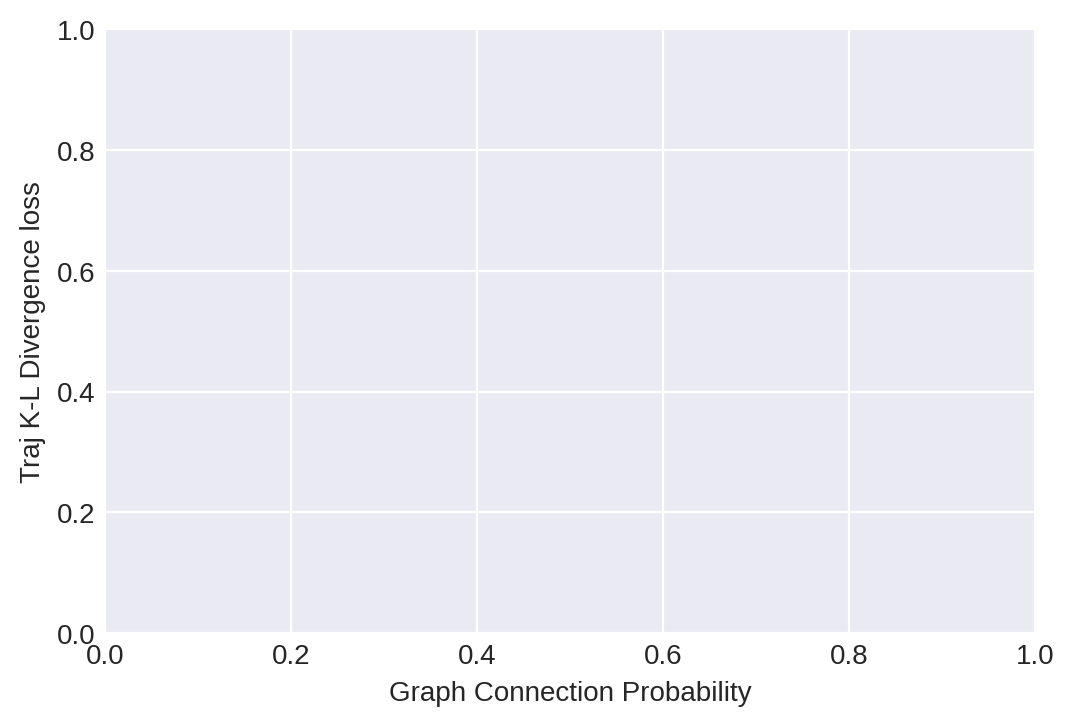

In [6]:
alpha = 0.5
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=200)
ax.set_xlabel('Graph Connection Probability')
ax.set_ylabel('Traj K-L Divergence loss')
# plt.scatter(p_values, np.array(box_T)[:,1], color='g', alpha=alpha)
ax.errorbar(p_values, box_T[:,1], yerr=(box_T[:,0], box_T[:,2]), fmt='o', color='C2', alpha=alpha,
           elinewidth=0.5, capsize=2, markersize=4)
ax.errorbar(p_values, box_F[:,1], yerr=(box_F[:,0], box_F[:,2]), fmt='o', color='C0', alpha=alpha,
           elinewidth=0.5, capsize=2, markersize=4)
ax.set_yscale('log')

In [21]:
upper_quartile = np.percentile(quant_certainty_T, 75)

In [22]:
upper_quartile

0.8974647617629501

In [ ]:
marker_colors = []
predictions = dat[:,3].astype(bool)
certainties = dat[:,2]
cross_entropy = dat[:,1]
K_L = dat[:,0]
true_nodes = dat[:,4]
predicted_nodes = dat[:,5]
alpha = 0.5
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probability)):
    if predictions[i]:
        marker_colors.append('C2')
    else:
        marker_colors.append('C0')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), dpi=600)
ax[0,0].set_xlabel('Graph Connection Probability')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability')
ax[0,1].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
fps_p_node = []
tps_p_node = []
for i, mc in enumerate(marker_colors):
    ax[0,0].plot(connecting_probability[i], K_L[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[0,1].plot(connecting_probability[i], certainties[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
        tps_p_node.append(connecting_probability[i])
    else:
        fps.append(certainties[i])
        fps_p_node.append(connecting_probability[i])
bins = np.linspace(0, 1, 9)
counts_t, bins_t, bars_t = ax[1,0].hist(tps, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,0].hist(fps, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.4, wspace=0.3)


bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[1,0].clear()
ax[1,0].plot(bins_t, accuracy, label='py0')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[1,0].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
ax[1,0].set_xlabel('Origin Inference Certainty')
ax[1,0].set_ylabel('Accuracy')
legend = ax[1,0].legend()
bins_p_node = np.unique(connecting_probability)
counts_f_p_node, bins_f_p_node, bars_f_p_node = ax[1,1].hist(fps_p_node, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
counts_t_p_node, bins_t_p_node, bars_t_p_node = ax[1,1].hist(tps_p_node, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.36, 1.42))
ax[1,1].clear()
accuracy_p_node = counts_t_p_node/(counts_f_p_node + counts_t_p_node)
non_nan_p_node = np.min(np.where(np.isfinite(accuracy_p_node)))
ax[1,1].plot(bins_t,accuracy_p_node, label='Maxent')
ax[1,1].set_xlabel('Graph Connection Probability')
ax[1,1].set_ylabel('Accuracy')
# plt.tight_layout()
# plt.savefig('adjust_p_grah.png', dpi=600)

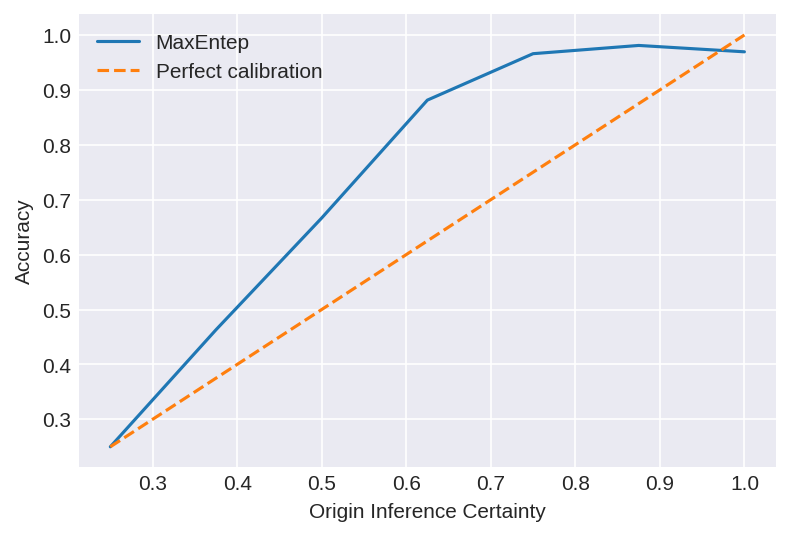

In [19]:
accuracy = counts_t/(counts_f + counts_t)
plt.figure(dpi=150)
plt.plot(bins_t, accuracy, label='py0')
non_nan = np.min(np.where(np.isfinite(accuracy)))
plt.plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
plt.xlabel('Origin Inference Certainty')
plt.ylabel('Accuracy')
legend = plt.legend()

## Finding [Time Horizon](https://arxiv.org/abs/2006.11913)

$ t_{max} \sim \frac{log(S_0)}{\mu (R_0 -1)}$

In [7]:
def density_fxn(n, area=area, xi=0.005):
        return 2. - tf.math.exp(-xi * n / area)
sparsed_mobility_matrix = py0.sparse_graph_mobility(graph, dense_mobility_matrix)
sparsed_mobility_matrix_norm = sparsed_mobility_matrix / np.sum(sparsed_mobility_matrix, axis=1, keepdims=True)
# finding effective population
effective_population = np.array(population)[np.newaxis, :] @  sparsed_mobility_matrix_norm
ntot = np.sum(effective_population, axis=1)
# k is the avergae number of contacts across the whole population
k = 10.
f = density_fxn(effective_population)
# finding normalization factor
z = ntot * k / np.sum(effective_population * density_fxn(effective_population), axis=1)
print(f'z = {z}')
M =  np.array(population)*np.einsum('il,jl,l->ij', sparsed_mobility_matrix_norm, sparsed_mobility_matrix_norm, np.squeeze(f/effective_population))
def kth_term(matrix, k):
        # This function outputs the spectral radius of the input matrix (k-> inf)
        # using Gelfand's formula
        matrix = np.linalg.matrix_power(matrix, k)
        f_norm = np.linalg.norm(matrix, 'fro')
        a = f_norm**(1.0/k)
        return a
spectral_radius = kth_term(M,75)
print(f'spectral_radius = {spectral_radius}')
mu = 1/7
beta = 0.05
beta_prime = 0.025
epsilon = 0.6
R_0 = z * 1 / mu * (epsilon * beta + (1-epsilon) * beta_prime) * spectral_radius
print(f'R_0 = {R_0}')
t_max = np.log(ntot) / mu / (R_0-1)
print(f't_max = {t_max}')

z = [5.56176962]
spectral_radius = 1.9309664654011192
R_0 = [3.00708538]
t_max = [55.07528889]
